In [1]:
# This notebook contains the code used to create the resutls of my thesis work
# It uses API code of the AbMetaAnalysis package I created, and data files that
# To run this notebook yourself you need to install the AbMetaAnalysis package and download 
# the data files from 
# you must also fill modify the input_dir and output_dir arguments in the first cell

In [2]:
import sys
from IPython.display import clear_output

In [3]:
# global arguments for running the notebook
input_dir = "/work/boazfr/data/thesis_prod"
output_dir = "/work/boazfr/data/thesis_prod"

In [4]:
import os
import pandas as pd

covid_case_metadata = pd.read_csv(
    os.path.join(input_dir, "metadata_files", "covid_case_metadata.tsv"), sep='\t'
).set_index(["study_id", "subject_id"])
covid_ctrl_metadata = pd.read_csv(
    os.path.join(input_dir, "metadata_files", "covid_ctrl_metadata.tsv"), sep='\t'
).set_index(["study_id", "subject_id"])
covid_case_test_metadata = pd.read_csv(
    os.path.join(input_dir, "metadata_files", "covid_case_test_metadata.tsv"), sep='\t'
).set_index(["study_id", "subject_id"])
covid_ctrl_test_metadata = pd.read_csv(
    os.path.join(input_dir, "metadata_files", "covid_ctrl_test_metadata.tsv"), sep='\t'
).set_index(["study_id", "subject_id"])

# labels for the covid test set
covid_test_labels = pd.concat(
    [pd.Series(True, index=covid_case_test_metadata.index), pd.Series(False, index=covid_ctrl_test_metadata.index)]
)
# labels for the covid cross validation set
covid_labels = pd.concat(
    [pd.Series(True, index=covid_case_metadata.index), pd.Series(False, index=covid_ctrl_metadata.index)] 
).drop(index=covid_test_labels.index)

for folder in ['distance_matrices',  'rep_clf_output',  'subsampled_files', 'figures', 'motifs']:
    if not os.path.isdir(os.path.join(output_dir, 'covid_output', folder)):
        os.makedirs(os.path.join(output_dir, 'covid_output', folder))

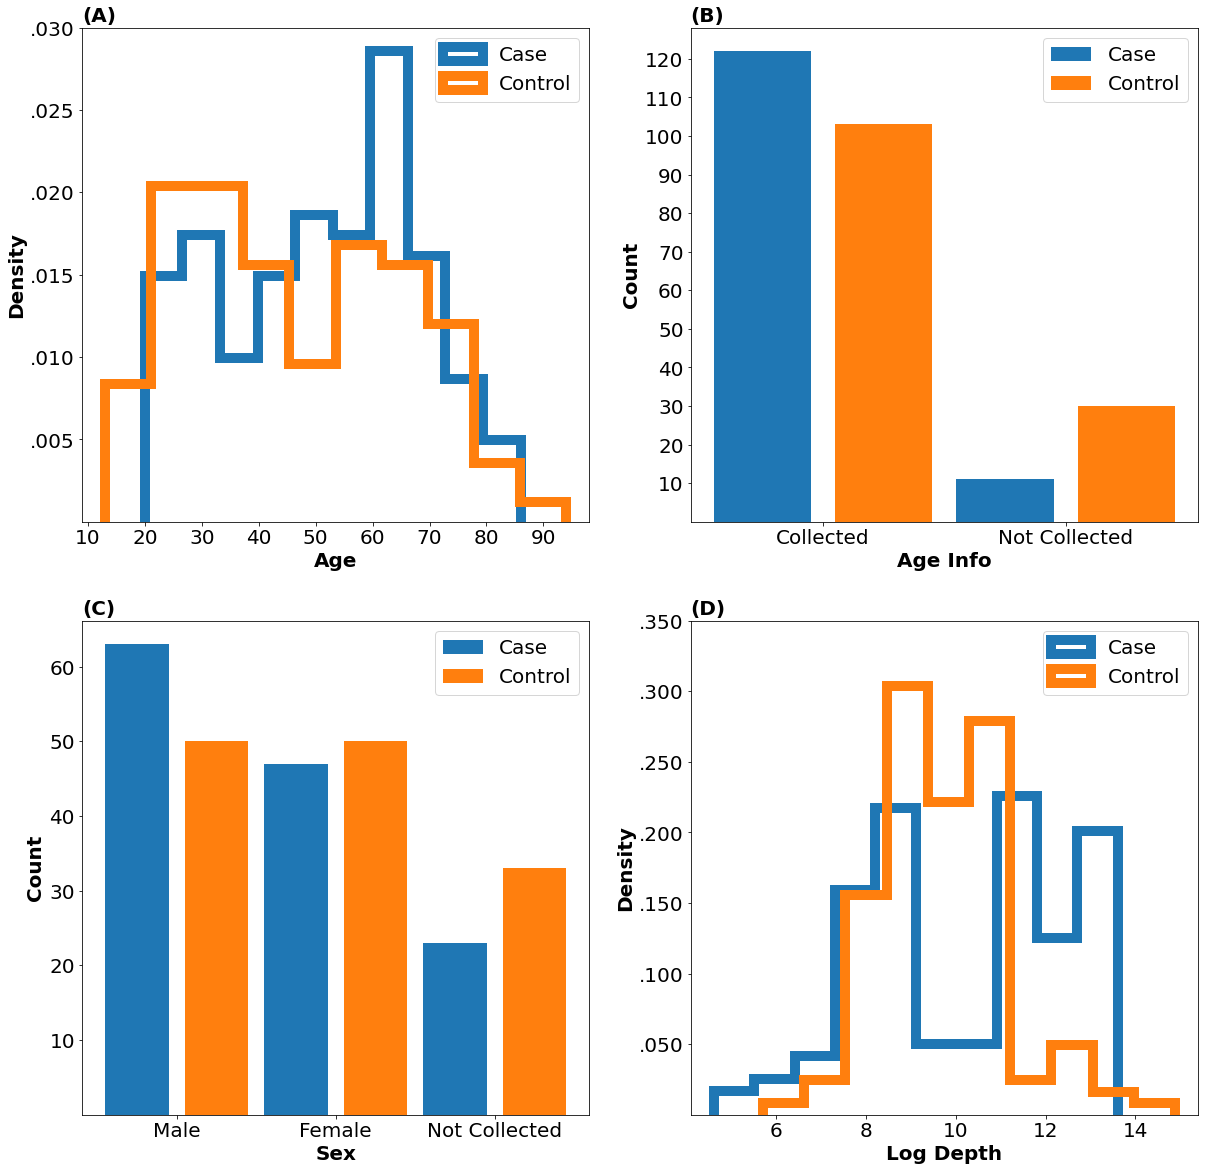

In [5]:
from matplotlib import pyplot as plt
import math

covid_case_ages = covid_case_metadata.loc[covid_labels.index[covid_labels]].age
covid_ctrl_ages = covid_ctrl_metadata.loc[covid_labels.index[~covid_labels]].age
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
ax = axes[0, 0]
ax.hist(covid_case_ages.loc[covid_case_ages.notna()].astype(float), histtype='step', density=True, lw=10)
ax.hist(covid_ctrl_ages.loc[covid_ctrl_ages.notna()].astype(float), histtype='step', density=True, lw=10)
ax.legend(labels=['Case', 'Control'], fontsize=20)
ax.set_yticks(ax.get_yticks()[1:], list(map(lambda x: '{:0>0.3f}'.format(x).replace('0.', '.'), ax.get_yticks()[1:])), fontsize=20)
ax.set_xticks(ax.get_xticks()[1:-1], list(map(lambda x: int(x), ax.get_xticks()))[1:-1], fontsize=20)
ax.set_xlabel('Age', fontsize=20, fontweight='bold')
ax.set_ylabel('Density', fontsize=20, fontweight='bold')
ax.set_title('(A)', fontsize=20, fontweight='bold', loc='left')
ax = axes[0, 1]
ax.bar([0,2], [covid_case_ages.notna().sum(), covid_case_ages.isna().sum()])
ax.bar([1,3], [covid_ctrl_ages.notna().sum(), covid_ctrl_ages.isna().sum()])
ax.set_xticks([0.5, 2.5], ['Collected', 'Not Collected'], fontsize=20)
ax.set_yticks(list(range(10,int(ax.get_yticks().max()-10),10)), list(range(10,int(ax.get_yticks().max()-10),10)), fontsize=20)
ax.set_xlabel('Age Info', fontsize=20, fontweight='bold')
ax.set_ylabel('Count', fontsize=20, fontweight='bold')
ax.set_title('(B)', fontsize=20, fontweight='bold', loc='left')
ax.legend(['Case', 'Control'], fontsize=20)
ax = axes[0, 1]
covid_case_sex = covid_case_metadata.loc[
    covid_labels.index[covid_labels]
].sex.apply(lambda x: x if not pd.isna(x) and (x in ['male', 'female']) else 'Not Collected')
covid_ctrl_sex = covid_ctrl_metadata.loc[
    covid_labels.index[~covid_labels]
].sex.apply(lambda x: x if not pd.isna(x) and (x in ['male', 'female']) else 'Not Collected')
ax = axes[1, 0]
ax.bar([0, 2, 4], covid_case_sex.value_counts(dropna=False))
ax.bar([1, 3, 5], covid_ctrl_sex.value_counts())
ax.set_xticks([0.5, 2.5, 4.5], ['Male', 'Female', 'Not Collected'], fontsize=20)
ax.set_yticks(list(range(10,int(ax.get_yticks().max()),10)), list(range(10,int(ax.get_yticks().max()),10)), fontsize=20)
ax.set_xlabel('Sex', fontsize=20, fontweight='bold')
ax.set_ylabel('Count', fontsize=20, fontweight='bold')
ax.set_title('(C)', fontsize=20, fontweight='bold', loc='left')
ax.legend(['Case', 'Control'], fontsize=20)

ax = axes[1, 1]
ax.hist(covid_case_metadata.loc[covid_labels.index[covid_labels]].sequences.apply(math.log), histtype='step', density=True, lw=10)
ax.hist(covid_ctrl_metadata.loc[covid_labels.index[~covid_labels]].sequences.apply(math.log), histtype='step', density=True, lw=10)
ax.legend(labels=['Case', 'Control'], fontsize=20)
ax.set_yticks(ax.get_yticks()[1:], list(map(lambda x: '{:0>0.3f}'.format(x).replace('0.', '.'), ax.get_yticks()[1:])), fontsize=20)
ax.set_xticks(ax.get_xticks()[1:-1], list(map(lambda x: int(x), ax.get_xticks()))[1:-1], fontsize=20)
ax.set_xlabel('Log Depth', fontsize=20, fontweight='bold')
ax.set_ylabel('Density', fontsize=20, fontweight='bold')
ax.set_title('(D)', fontsize=20, fontweight='bold', loc='left')
fig.savefig(os.path.join(output_dir, 'covid_output', 'figures', "subjects_metadata.pdf"))

In [6]:
# to subsample the data files we first need within-sample clustering for each
# sample file. if the file have more than 100000 we random subsample 100000 sequences
# and use them for the within-sample clustering else the clustering using DefineClones
# can take very long time - you can change this configuration with the max_sequences argument.
# if the files already have a match cluster_id field the clustering will be skipped. The
# files in the data download folder should have this field. To force within-sample clustering
# you can change the Force=False argument in the cluster_sample call to Force=True
from AbMetaAnalysis.Clustering import cluster_sample

for input_file in pd.concat([covid_case_metadata.input_file, covid_ctrl_metadata.input_file]):
    cluster_sample(
        airr_seq_df_file_path=os.path.join(input_dir, input_file),
        max_sequences=100000,
        linkage='complete',
        dist_th=0.0,
        force=False
    )
    clear_output()

In [7]:
# if you downloaded the complete data folder the subsampling will be skipped as subsampled files with
# the correct path will already exist. in order to force subsampling you can change the force argument
# to True in the subsample_by_n_clusters and/or subsample_by_n_sequences calls
from AbMetaAnalysis.SubSample import sample_by_n_clusters, sample_by_n_sequences

sample_by_n_clusters(
    metadata=covid_case_metadata.append(covid_ctrl_metadata),
    input_dir=input_dir,
    output_dir=os.path.join(output_dir, 'covid_output', 'subsampled_files'),
    n_clusters_values=[100],
    max_seq_per_cluster_values=[1],
    cluster_id_col_values=['subject_cluster_id_complete_linkage_dist_0.0'],
    force=False    
)

sample_by_n_sequences(
    metadata=covid_case_metadata.append(covid_ctrl_metadata),
    input_dir=input_dir,
    output_dir=os.path.join(output_dir, 'covid_output', 'subsampled_files'),
    n_sequences_values=[100],
    force=False    
)

file /work/boazfr/data/thesis_prod/covid_output/subsampled_files/top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv already exists - skipping sampling
file /work/boazfr/data/thesis_prod/covid_output/subsampled_files/random_100_sequences_samples.tsv already exists - skipping sampling


<ipython-input-7-43badb5624a0>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metadata=covid_case_metadata.append(covid_ctrl_metadata),
<ipython-input-7-43badb5624a0>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metadata=covid_case_metadata.append(covid_ctrl_metadata),


In [8]:
# Group sequences in the sampled files and compute and save pair-wise distance matrices 
# of the hamming distance between the junctions. The distance matrices are required for the 
# repertoire classifications. The function checks for pre-existing distance matrices and skips
# if exists. The data folder that you downloaded should include the distance matrices but if you want to
# force a new computation you can change the force argument in the save_distance_matrices function call to True. 
from AbMetaAnalysis.Utilities import load_sampled_airr_seq_df
from AbMetaAnalysis.Clustering import save_distance_matrices

save_distance_matrices(
    load_sampled_airr_seq_df(
        file_path=os.path.join(
            output_dir, 'covid_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
        ),
        labels=covid_labels.append(covid_test_labels),
        v_call_field="v_call_original",
        group_mode="family"
    ),
    os.path.join(
        output_dir, 'covid_output', 'distance_matrices', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
    ),
    force=False
)

save_distance_matrices(
    load_sampled_airr_seq_df(
        file_path=os.path.join(
            output_dir, 'covid_output', 'subsampled_files', 'random_100_sequences_samples.tsv'
        ),
        labels=covid_labels.append(covid_test_labels),
        v_call_field="v_call_original",
        group_mode="family"
    ),
    os.path.join(
        output_dir, 'covid_output', 'distance_matrices', 'random_100_sequences_samples'
    ),
    force=False
)

<ipython-input-8-5969c58f2b5d>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels=covid_labels.append(covid_test_labels),
/home/boaz/.local/lib/python3.8/site-packages/AbMetaAnalysis/Utilities.py:728: DtypeWarning: Columns (52,71,72,73,75,76,78,79,80,81,82,83,84,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  airr_seq_df = pd.read_csv(
<ipython-input-8-5969c58f2b5d>:29: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels=covid_labels.append(covid_test_labels),
/home/boaz/.local/lib/python3.8/site-packages/AbMetaAnalysis/Utilities.py:728: DtypeWarning: Columns (52,81,82,83,85,86,88,89,90,92,93,94,95,96,98) have mixed types. Specify dtype option on import or set low_memory=False.
  airr_seq_df = pd.read_csv(


In [9]:
# This cell run the covid repertoire samples classifier 100 folds cross validation. The cv results file should
# already be in the data directory you downladed, so the code in the cell will first try to load them. If you want 
# to force the cross validation run change the value of the covid_force_cv parameter to True but keep in mind
# that it might take some time - depending on the number of cores you have.
from AbMetaAnalysis.Utilities import load_sampled_airr_seq_df
from AbMetaAnalysis.TestRepClassifier import test_rep_classifier, load_rep_clf_results, save_rep_clf_results
import numpy as np

covid_force_cv = False

cluster_sampling_result_metrics, cluster_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
    'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.2, 'fs_method': 'naive'}
)
if covid_force_cv or cluster_sampling_result_metrics is None or cluster_sampling_result_folds is None:
    cluster_sampling_result_metrics, cluster_sampling_result_folds = test_rep_classifier(
        airr_seq_df=load_sampled_airr_seq_df(
            file_path=os.path.join(
                output_dir, 'covid_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
            ),
            labels=covid_labels,
            v_call_field="v_call_original",
            group_mode="family"
        ),
        labels=covid_labels,
        dist_mat_dir = os.path.join(
            output_dir, 'covid_output', 'distance_matrices', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
        ),
        train_only_labels=None,
        n_splits=10,
        n_repeats=10,
        case_th_values=[1],
        ctrl_th_values=[0],
        dist_th_values=[0.2],
        feature_selection_cfg_values=[{'method': 'naive'}]
    )
    save_rep_clf_results(
        cluster_sampling_result_metrics, 
        cluster_sampling_result_folds,
        os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
        'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
    )
    clear_output()


random_sampling_result_metrics, random_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
    'random_100_sequences_samples',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.2, 'fs_method': 'naive'}
)    
if covid_force_cv or random_sampling_result_metrics is None or random_sampling_result_folds is None:
    random_sampling_result_metrics, random_sampling_result_folds = test_rep_classifier(
        airr_seq_df=load_sampled_airr_seq_df(
            file_path=os.path.join(
                output_dir, 'covid_output', 'subsampled_files', 'random_100_sequences_samples.tsv'
            ),
            labels=covid_labels,
            v_call_field="v_call_original",
            group_mode="family"
        ),
        labels=covid_labels,
        dist_mat_dir=os.path.join(
            output_dir, 'covid_output', 'distance_matrices', 'random_100_sequences_samples'
        ),
        train_only_labels = None,
        n_splits=10,
        n_repeats=10,
        case_th_values=[1],
        ctrl_th_values=[0],
        dist_th_values=[0.2],
        feature_selection_cfg_values=[{'method': 'naive'}]
    )
    save_rep_clf_results(
        random_sampling_result_metrics, 
        random_sampling_result_folds, 
        os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
        'random_100_sequences_samples'
    )
    clear_output()

print(
    'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1 100 CV folds:\n'
    '    accuracy: {}, precision: {}, recall: {}'.format(
        cluster_sampling_result_metrics.accuracy_score.mean(), 
        cluster_sampling_result_metrics.precision_score.mean(),
        cluster_sampling_result_metrics.recall_score.mean()
    )
)
print(
    'random_100_sequences_samples 100 CV folds:\n'
    '    accuracy: {}, precision: {}, recall: {}'.format(
        random_sampling_result_metrics.accuracy_score.mean(), 
        random_sampling_result_metrics.precision_score.mean(),
        random_sampling_result_metrics.recall_score.mean()
    )
)

2023-04-11 16:23:29,986	INFO worker.py:1553 -- Started a local Ray instance.
2023-04-11 16:23:30,352	INFO packaging.py:503 -- Creating a file package for local directory '/work/boazfr/dev/packages'.
2023-04-11 16:23:30,469	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_989683265b8fd766.zip' (1.12MiB) to Ray cluster...
2023-04-11 16:23:30,493	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_989683265b8fd766.zip'.


top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1 100 CV folds:
    accuracy: 0.7474786324786326, precision: 0.8848971861471862, recall: 0.5761538461538462
random_100_sequences_samples 100 CV folds:
    accuracy: 0.6248575498575498, precision: 0.8326865079365079, recall: 0.3168681318681318


In [10]:
random_big_sampling_result_metrics, random_big_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
    'random_1000_sequences_samples',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.2, 'fs_method': 'naive'}
)
print(
    'random_1000_sequences_samples 100 CV folds:\n'
    '    accuracy: {}, precision: {}, recall: {}'.format(
        random_sampling_result_metrics.accuracy_score.mean(), 
        random_sampling_result_metrics.precision_score.mean(),
        random_sampling_result_metrics.recall_score.mean()
    )
)

random_1000_sequences_samples 100 CV folds:
    accuracy: 0.6248575498575498, precision: 0.8326865079365079, recall: 0.3168681318681318


In [11]:
# run the model on the test set
from AbMetaAnalysis.Utilities import load_sampled_airr_seq_df
from AbMetaAnalysis.TestRepClassifier import test_fold


force_test_set_clf = True
covid_test_result_metrics, covid_test_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
    'test_set',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.2, 'fs_method': 'naive'}
)
if force_test_set_clf or covid_test_result_metrics is None or covid_test_result_folds is None:

    covid_test_result_metrics, covid_test_result_folds = test_fold(
        airr_seq_df=load_sampled_airr_seq_df(
            file_path=os.path.join(
                output_dir, 'covid_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
            ),
            labels=covid_labels.append(covid_test_labels),
            v_call_field="v_call_original",
            group_mode="family"
        ),
        train_labels=covid_labels,
        test_labels=covid_test_labels,
        dist_mat_dir = os.path.join(
            output_dir, 'covid_output', 'distance_matrices', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
        ),
        dist_th=0.2,
        case_th=1,
        ctrl_th=0,
        feature_selection_cfg_values=[{'method': 'naive'}]
    )
    save_rep_clf_results(
        covid_test_result_metrics, 
        covid_test_result_folds, 
        os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
        'test_set'
    )
    
print(
    'Covid test set results:\n'
    '    accuracy: {}, precision: {}, recall: {}'.format(
        covid_test_result_metrics.accuracy_score.mean(), 
        covid_test_result_metrics.precision_score.mean(),
        covid_test_result_metrics.recall_score.mean()
    )
)

<ipython-input-11-b839e286c9c8>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels=covid_labels.append(covid_test_labels),
/home/boaz/.local/lib/python3.8/site-packages/AbMetaAnalysis/Utilities.py:728: DtypeWarning: Columns (52,71,72,73,75,76,78,79,80,81,82,83,84,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  airr_seq_df = pd.read_csv(


building feature table
creating rep classifier
support                  26
accuracy_score     0.711538
recall_score            0.5
precision_score    0.866667
f1-score           0.634146
case_th                   1
ctrl_th                   0
dist_th                 0.2
fs_method             naive
k                       NaN
kmer_clustering        None
Name: 0, dtype: object
Covid test set results:
    accuracy: 0.7115384615384616, precision: 0.8666666666666667, recall: 0.5


/home/boaz/.local/lib/python3.8/site-packages/AbMetaAnalysis/Utilities.py:728: DtypeWarning: Columns (52,71,72,73,75,76,78,79,80,81,82,83,84,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  airr_seq_df = pd.read_csv(
/home/boaz/.local/lib/python3.8/site-packages/AbMetaAnalysis/Utilities.py:728: DtypeWarning: Columns (52,81,82,83,85,86,88,89,90,92,93,94,95,96,98) have mixed types. Specify dtype option on import or set low_memory=False.
  airr_seq_df = pd.read_csv(


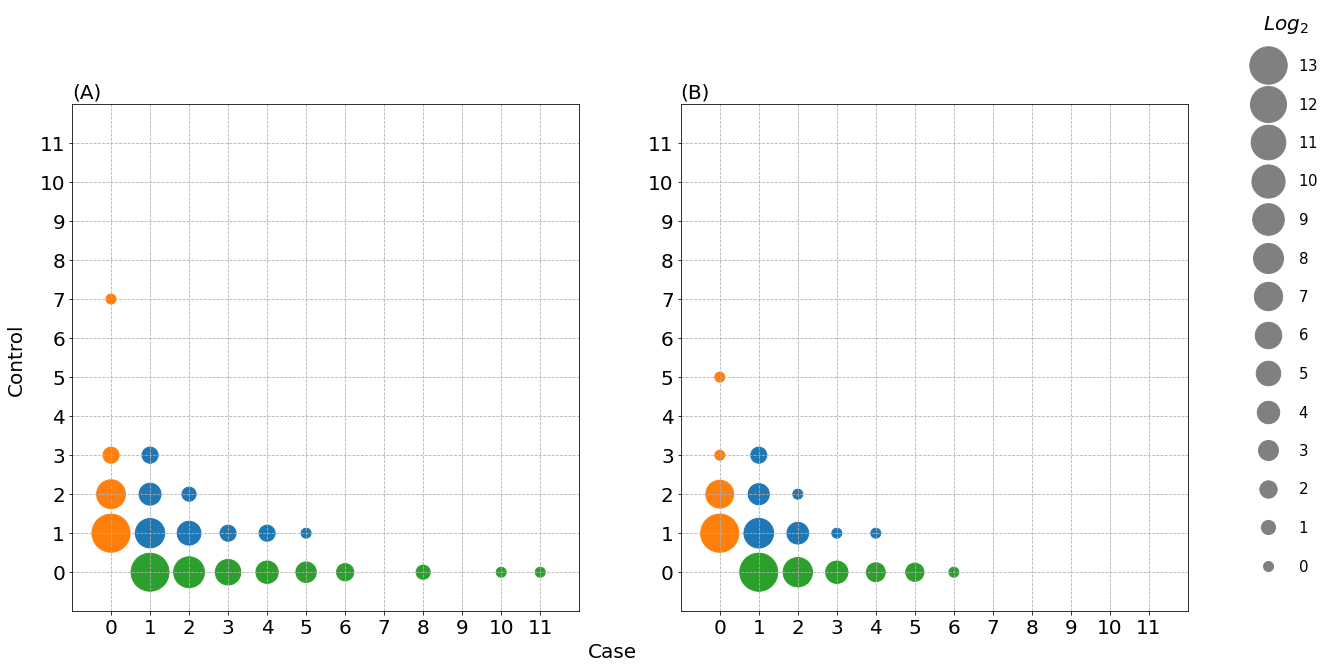

In [12]:
from AbMetaAnalysis.Utilities import load_sampled_airr_seq_df
from AbMetaAnalysis.EDA import get_case_control_sequence_df
from AbMetaAnalysis.Plot import plot_features_side_by_side
from matplotlib import pyplot as plt

covid_study2alias = {
   "covid_bar_ilan": "1",
   "IR-Binder-000001": "2",
   "PRJNA645245": "3",
   "PRJNA630455": "4",
   "PRJNA628125": "5",
   "PRJNA715378": "6",
   "PRJNA839749": "7",
   "PRJEB28370": "8",
   "SRP001460": "9",
   "PRJNA338795": "10",
   "PRJEB1289": "11",
   "PRJNA280743": "12",
   "PRJNA270742": "13"
}
covid_aliase2study = {val: key for key, val in covid_study2alias.items()}
covid_case_aliases = ["1", "2", "3", "4", "5", "6"]
covid_ctrl_aliases = ["7", "8", "9", "10", "11", "12", "13"]

cluster_sampling_covid_airr_seq_df=load_sampled_airr_seq_df(
    file_path=os.path.join(
        output_dir, 'covid_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
    ),
    labels=covid_labels,
    v_call_field="v_call_original",
    group_mode="family"
)
covid_case_airr_seq_df, covid_ctrl_airr_seq_df, cluster_sampling_covid_feature_table = get_case_control_sequence_df(
    airr_seq_df=cluster_sampling_covid_airr_seq_df,
    labels=covid_labels,
    dist_mat_dir=os.path.join(
        output_dir, 'covid_output', 'distance_matrices', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
    ),
    dist_th=0.2
)

random_sampling_covid_airr_seq_df=load_sampled_airr_seq_df(
    file_path=os.path.join(
        output_dir, 'covid_output', 'subsampled_files', 'random_100_sequences_samples.tsv'
    ),
    labels=covid_labels,
    v_call_field="v_call_original",
    group_mode="family"
)
__, __, random_sampling_covid_feature_table = get_case_control_sequence_df(
    airr_seq_df=random_sampling_covid_airr_seq_df,
    labels=covid_labels,
    dist_mat_dir=os.path.join(
        output_dir, 'covid_output', 'distance_matrices', 'random_100_sequences_samples'
    ),
    dist_th=0.2
)

plot_features_side_by_side({'A': cluster_sampling_covid_feature_table, 'B': random_sampling_covid_feature_table}, covid_labels)
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'between_samples_clusters.pdf'))

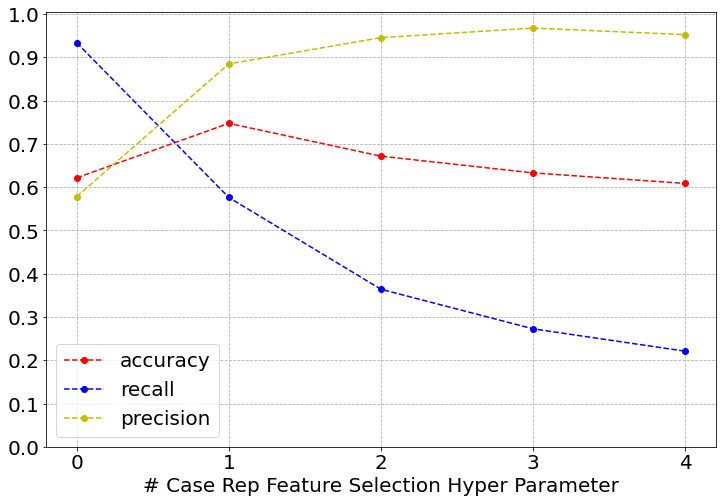

In [13]:
accuracy, recall, precision  = [], [], []

n_case_values = [0, 1, 2, 3, 4]
for n_case in n_case_values:
    cluster_sampling_result_metrics, __ = load_rep_clf_results(
        os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
        'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1',
        {'case_th': n_case, 'ctrl_th': 0, 'dist_th': 0.2, 'fs_method': 'naive'}
    )
    accuracy.append(cluster_sampling_result_metrics.accuracy_score.mean())
    recall.append(cluster_sampling_result_metrics.recall_score.mean())
    precision.append(cluster_sampling_result_metrics.precision_score.mean())
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(n_case_values, accuracy, '--r', marker='o')
ax.plot(n_case_values, recall, '--b', marker='o')
ax.plot(n_case_values, precision, '--y', marker='o')
ax.legend(labels=['accuracy', 'recall', 'precision'], fontsize=20)
ax.set_xlabel('# Case Rep Feature Selection Hyper Parameter', fontsize=20)
ax.set_xticks(n_case_values)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(axis="both", labelsize=20)
ax.grid(True, ls='--')

plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'acc_metrics_vs_n_case_hyper_param.pdf'))

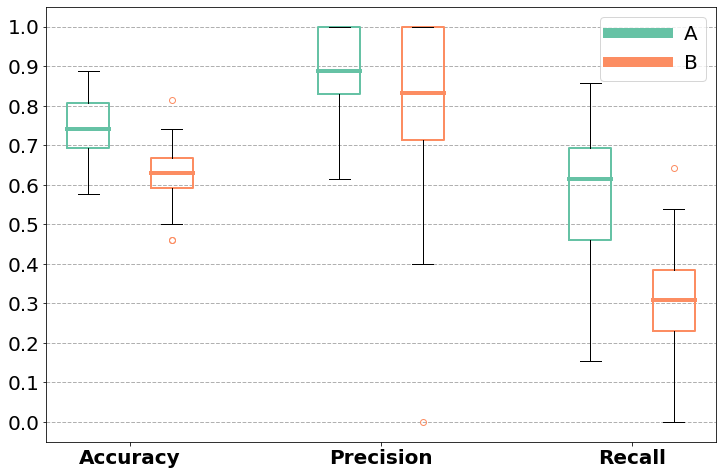

In [14]:
# plot comparing classification accuracy metrics when using different subsampling types 
from AbMetaAnalysis.TestRepClassifier import load_rep_clf_results
from AbMetaAnalysis.Plot import plot_results_side_by_side
from matplotlib import pyplot as plt

cluster_sampling_result_metrics, cluster_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
    'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.2, 'fs_method': 'naive'}
)
random_sampling_result_metrics, random_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'covid_output', 'rep_clf_output'), 
    'random_100_sequences_samples',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.2, 'fs_method': 'naive'}
)  

plot_results_side_by_side(
    results_l=[
        cluster_sampling_result_metrics, 
        random_sampling_result_metrics
    ],
    name_l=['A', 'B'],
    figsize=(12, 8)
)
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'clf_metrics_vs_sample_method.pdf'))

<ipython-input-15-e9ec1b46f3b0>:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covid_male_labels = pd.Series(True, index=covid_case_metadata.loc[covid_case_metadata.sex == 'male'].index).append(
<ipython-input-15-e9ec1b46f3b0>:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covid_female_labels = pd.Series(True, index=covid_case_metadata.loc[covid_case_metadata.sex == 'female'].index).append(


pvalue: 0.27667583075046676


<Figure size 640x480 with 0 Axes>

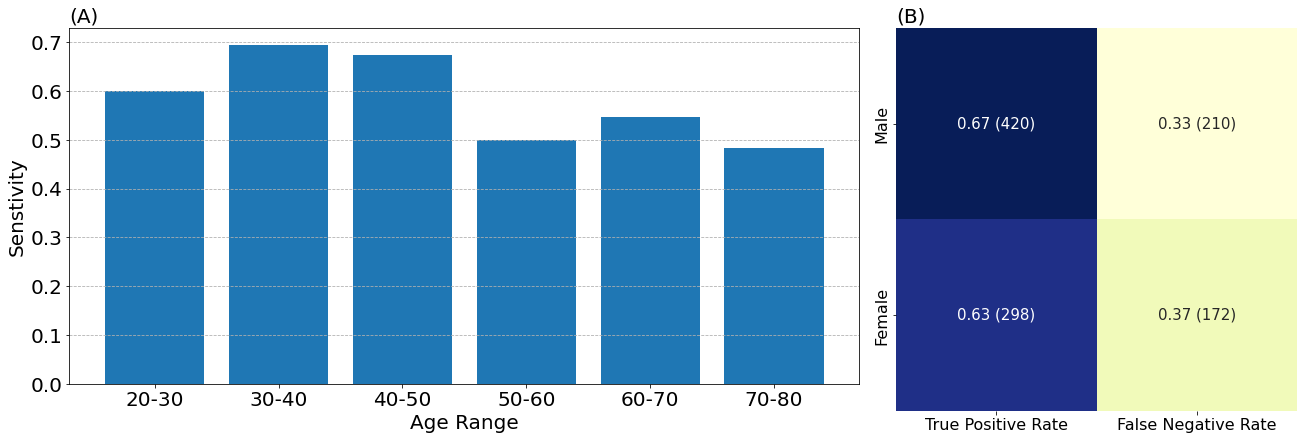

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

covid_male_labels = pd.Series(True, index=covid_case_metadata.loc[covid_case_metadata.sex == 'male'].index).append(
  pd.Series(False, index=covid_ctrl_metadata.loc[covid_ctrl_metadata.sex == 'male'].index)  
)
covid_male_labels.drop(index=set(covid_male_labels.index).intersection(covid_test_labels.index), inplace=True)
covid_female_labels = pd.Series(True, index=covid_case_metadata.loc[covid_case_metadata.sex == 'female'].index).append(
  pd.Series(False, index=covid_ctrl_metadata.loc[covid_ctrl_metadata.sex == 'female'].index)  
)
covid_female_labels.drop(index=set(covid_female_labels.index).intersection(covid_test_labels.index), inplace=True)

cont_table = np.array(
    [
        [(cluster_sampling_result_folds.loc[covid_male_labels.index[covid_male_labels]]==True).sum().sum(), 
         (cluster_sampling_result_folds.loc[covid_male_labels.index[covid_male_labels]]==False).sum().sum()
        ],
        [(cluster_sampling_result_folds.loc[covid_female_labels.index[covid_female_labels]]==True).sum().sum(), 
         (cluster_sampling_result_folds.loc[covid_female_labels.index[covid_female_labels]]==False).sum().sum()
        ],
    ]
)
print(f'pvalue: {fisher_exact(cont_table)[1]}')

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(18, 6))
gridspec = axs[0].get_subplotspec().get_gridspec()
for a in axs[:]:
    a.remove()
subfig = fig.add_subfigure(gridspec[:2])
axsLeft = subfig.subplots(1, 1)
subfig = fig.add_subfigure(gridspec[2:])
axsRight = subfig.subplots(1, 1)

norm_cont_table = np.transpose(np.transpose(cont_table)/cont_table.sum(axis=1))
cont_table_annot= np.array(
 [
     [f'{norm_cont_table[0,0]:.2f} ({cont_table[0,0]})', f'{norm_cont_table[0,1]:.2f} ({cont_table[0,1]})'],
     [f'{norm_cont_table[1,0]:.2f} ({cont_table[1,0]})', f'{norm_cont_table[1,1]:.2f} ({cont_table[1,1]})']
 ]  
)
sns.heatmap(
    norm_cont_table, annot=cont_table_annot, fmt="", cmap="YlGnBu", ax=axsRight, cbar=False, annot_kws={'size': 15}
)
axsRight.set_xticks([i+0.5 for i in range(cont_table.shape[0])], ['True Positive Rate', 'False Negative Rate'], fontsize=16, rotation=0)
axsRight.set_yticks([i+0.5 for i in range(cont_table.shape[1])], ['Male', 'Female'], fontsize=16, rotation=90)
axsRight.set_title('(B)', fontsize=20, loc='left')

recall_vs_age = pd.DataFrame(columns=['age', 'TP', 'support'])
for age, frame_index in covid_case_metadata.loc[covid_labels.index[covid_labels]].index.groupby(
    covid_case_metadata.loc[covid_labels.index[covid_labels]].age
).items():
    if age is np.nan:
        continue
    recall_vs_age.loc[len(recall_vs_age), ['age', 'TP', 'support']] = [
        int(float(age)),
        (cluster_sampling_result_folds.loc[frame_index]==True).sum().sum(), 
        cluster_sampling_result_folds.loc[frame_index].notna().sum().sum()
    ]
x, y = [], []
for age_min, age_max in zip(range(20, 80, 10), range(30, 90, 10)):
    x.append(f'{age_min}-{age_max}')
    y.append(
        recall_vs_age.loc[(recall_vs_age.age >= age_min) & (recall_vs_age.age < age_max)].TP.sum() /
        recall_vs_age.loc[(recall_vs_age.age >= age_min) & (recall_vs_age.age < age_max)].support.sum()    
    )
axsLeft.bar(x, y)
axsLeft.set_ylabel('Senstivity', fontsize=20)
axsLeft.set_xlabel('Age Range', fontsize=20)
axsLeft.tick_params(labelsize=20)
axsLeft.grid(axis='y', ls='--')
axsLeft.set_title('(A)', fontsize=20, loc='left')
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'covid_results_analysis.pdf'))

mannwhitneyu v_family usage by sample test:
         pvalue pvalue_corrected reject
IGHV4       0.0              0.0   True
IGHV3       0.0              0.0   True
IGHV2  0.000039         0.000194   True
IGHV1  0.000542         0.002168   True
IGHV5  0.116183         0.309622  False
IGHV6  0.154565         0.309622  False
IGHV7  0.809948         0.809948  False
mannwhitneyu v_family usage by study test:
         pvalue pvalue_corrected reject
IGHV4  0.011072          0.03285   True
IGHV2  0.314103         0.529545  False
IGHV1  0.527389         0.529545  False
         pvalue pvalue_corrected reject
IGHV3  0.036713         0.036713   True


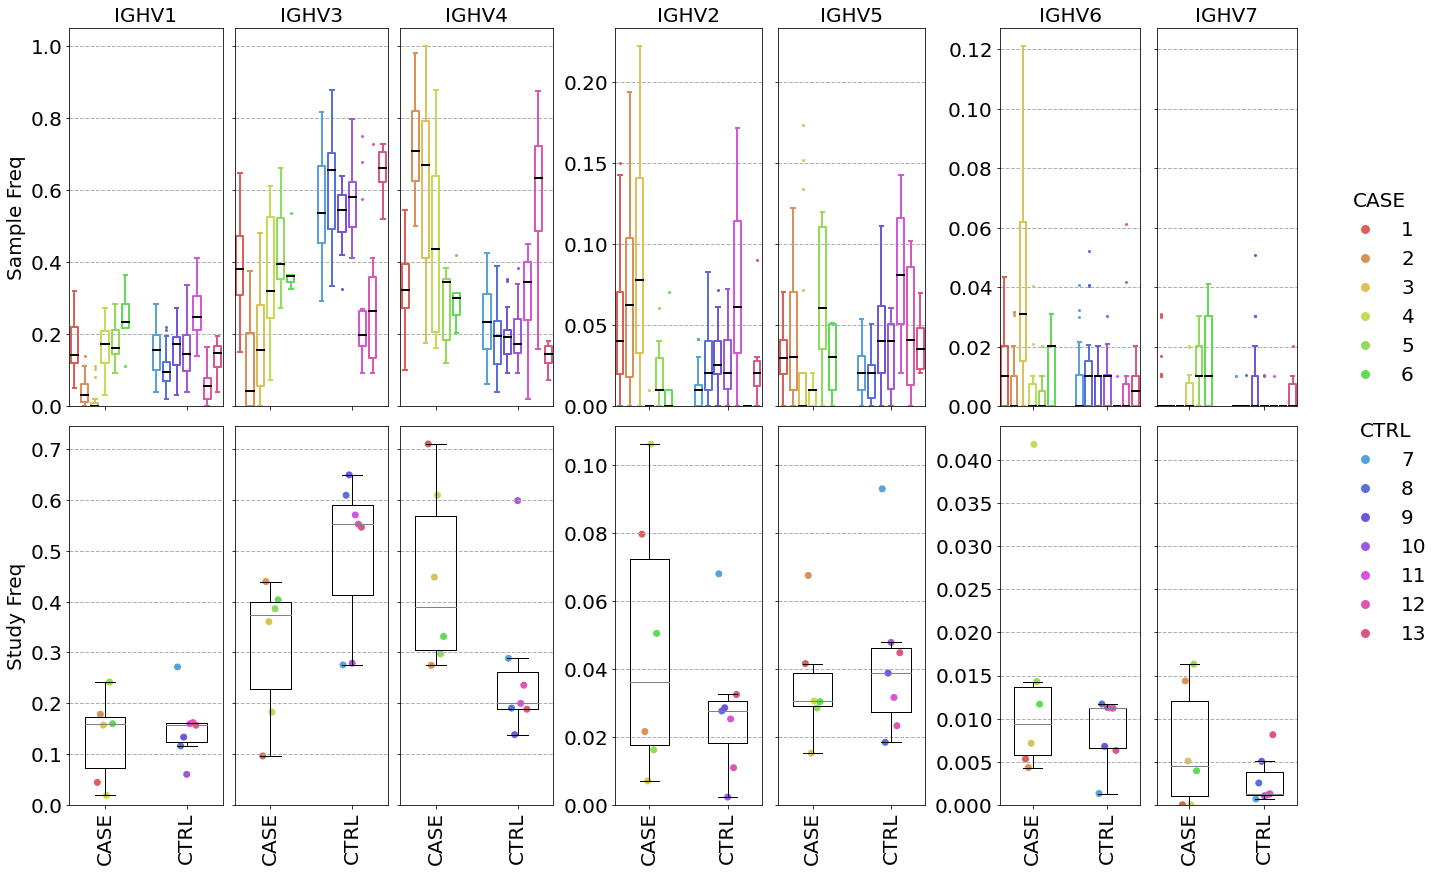

In [18]:
# The covid v_family motifs analysis 
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from AbMetaAnalysis.EDA import get_motif_analysis, mannwhitneyu_test, count_v_family_by_subj, load_motifs_analysis, save_motifs_analysis
from AbMetaAnalysis.Plot import boxplot_features, create_studies_legend_handles

force_v_family_analysis = False
covid_by_subj_v_family_df, covid_by_study_v_family_df, covid_by_label_v_family_df = load_motifs_analysis(
    motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='v_family'
)
if force_v_family_analysis or covid_by_subj_v_family_df is None or covid_by_study_v_family_df is None or covid_by_label_v_family_df is None:
    covid_by_subj_v_family_df, covid_by_study_v_family_df, covid_by_label_v_family_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        count_v_family_by_subj,
        outlier_th=3,
        ci_alpha=0.1
    )
    save_motifs_analysis(
        by_subj_motif_df=covid_by_subj_v_family_df, 
        by_study_motif_df=covid_by_study_v_family_df, 
        by_label_motif_df=covid_by_label_v_family_df,
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='v_family'
    )

    
print("mannwhitneyu v_family usage by sample test:")
print(
    mannwhitneyu_test(
        df=covid_by_subj_v_family_df,
        confidence_th=0.05,
        alternative='two-sided',
        adjustment_method='holm-sidak',
        y='prop'
    )
)

print("mannwhitneyu v_family usage by study test:")
print(
    mannwhitneyu_test(
        df=covid_by_study_v_family_df.loc[:, (slice(None), ['IGHV1', 'IGHV2', 'IGHV4'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)
print(
    mannwhitneyu_test(
        df=covid_by_study_v_family_df.loc[:, (slice(None), ['IGHV3'])],
        confidence_th=0.05,
        alternative='less',
        adjustment_method='holm-sidak',
        y='prop'
    )
)

fig, axs = plt.subplots(1, 7, constrained_layout=True, figsize=(18, 12))
gridspec = axs[0].get_subplotspec().get_gridspec()
for a in axs[:]:
    a.remove()
subfig = fig.add_subfigure(gridspec[0:3])
axsLeft = subfig.subplots(2, 3, sharex="col", sharey="row")
subfig = fig.add_subfigure(gridspec[3:5])
axsCenter = subfig.subplots(2, 2, sharex="col", sharey="row")
subfig = fig.add_subfigure(gridspec[5:7])
axsRight = subfig.subplots(2, 2, sharex="col", sharey="row")
case_ctrl_color_diff=3
colors = sns.color_palette("hls", len(covid_by_study_v_family_df) + case_ctrl_color_diff)
case_handles = create_studies_legend_handles(covid_case_aliases, colors)
ctrl_handles = create_studies_legend_handles(covid_ctrl_aliases, colors[len(covid_case_aliases) + case_ctrl_color_diff:])

boxplot_features(
    by_subj_df=covid_by_subj_v_family_df.loc[:, (slice(None), ['IGHV1', 'IGHV3', 'IGHV4'])],
    by_study_df=covid_by_study_v_family_df.loc[:, (slice(None), ['IGHV1', 'IGHV3', 'IGHV4'])],
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axsLeft,
    case_ctrl_color_diff=3,
    outlier_th=2.5,
    y='prop',
    ylabel="Freq"
)
boxplot_features(
    by_subj_df=covid_by_subj_v_family_df.loc[:, (slice(None), ['IGHV2', 'IGHV5'])],
    by_study_df=covid_by_study_v_family_df.loc[:, (slice(None), ['IGHV2', 'IGHV5'])],
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axsCenter,
    case_ctrl_color_diff=3,
    outlier_th=2.5,
    y='prop',
    ylabel=None
)
boxplot_features(
    by_subj_df=covid_by_subj_v_family_df.loc[:, (slice(None), ['IGHV6', 'IGHV7'])],
    by_study_df=covid_by_study_v_family_df.loc[:, (slice(None), ['IGHV6', 'IGHV7'])],
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axsRight,
    case_ctrl_color_diff=3,
    outlier_th=2.5,
    y='prop',
    ylabel=None
)

case_legend = subfig.legend(handles=case_handles, title='CASE', title_fontsize=20, fontsize=20, loc=(1.1, 0.55))
case_legend.get_frame().set_linewidth(0.0)
ctrl_legend = subfig.legend(handles=ctrl_handles, title='CTRL', title_fontsize=20, fontsize=20, loc=(1.1, 0.25))
ctrl_legend.get_frame().set_linewidth(0.0)
    
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'v_family_usage.pdf'), bbox_inches='tight')

del axsLeft, axsCenter, axsRight, covid_by_subj_v_family_df, covid_by_study_v_family_df, covid_by_label_v_family_df, fig, axs, gridspec, case_legend, ctrl_legend

In [20]:
from AbMetaAnalysis.EDA import get_motif_analysis, mannwhitneyu_test, load_motifs_analysis, save_motifs_analysis
from AbMetaAnalysis.EDA import get_by_subj_motif_analysis_df, get_by_study_motif_analysis_df
from changeo.Gene import getFamily, getGene, getAllele

def count_v_allele_by_subj(airr_seq_df, v_call_field="v_call_original"):
    return airr_seq_df.groupby(['study_id', 'subject_id']).apply(
        lambda x: pd.DataFrame(x[v_call_field].apply(getAllele).value_counts()).transpose()
    ).droplevel(2).fillna(0)

covid_by_subj_v_allele_df, covid_by_study_v_allele_df, covid_by_label_v_allele_df = get_motif_analysis(
    covid_case_airr_seq_df,
    covid_ctrl_airr_seq_df,
    count_v_allele_by_subj,
    outlier_th=3,
    ci_alpha=0.1
)

# force_v_gene_analysis = False
# covid_by_subj_v_gene_df, covid_by_study_v_gene_df, covid_by_label_v_gene_df = load_motifs_analysis(
#     motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='v_gene'
# )

<ipython-input-21-17671aa174d9>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covid_by_study_ighv4_df = pd.concat(


mannwhitneyu v_gene usage by subject test:
              pvalue pvalue_corrected reject
IGHV4-59         0.0              0.0   True
IGHV4-30-2       0.0         0.000003   True
IGHV4-4      0.00014         0.001122   True
IGHV4-28    0.035697         0.224658  False
IGHV4-30-4  0.074798          0.37278  False
IGHV4-34    0.091696         0.381762  False
IGHV4-31    0.492589         0.933712  False
IGHV4-38-2  0.565384         0.933712  False
IGHV4-61    0.574879         0.933712  False
IGHV4-39    0.999899         0.999899  False
mannwhitneyu v_gene usage by study test:
              pvalue pvalue_corrected reject
IGHV4-59    0.000583         0.005812   True
IGHV4-30-2  0.006993         0.061205  False
IGHV4-4     0.068765         0.434444  False
IGHV4-34    0.147436         0.672592  False
IGHV4-30-4  0.182984          0.70257  False
IGHV4-28    0.417832         0.933129  False
IGHV4-31    0.634615         0.982176  False
IGHV4-61    0.817016         0.993873  False
IGHV4-38-2  0.87

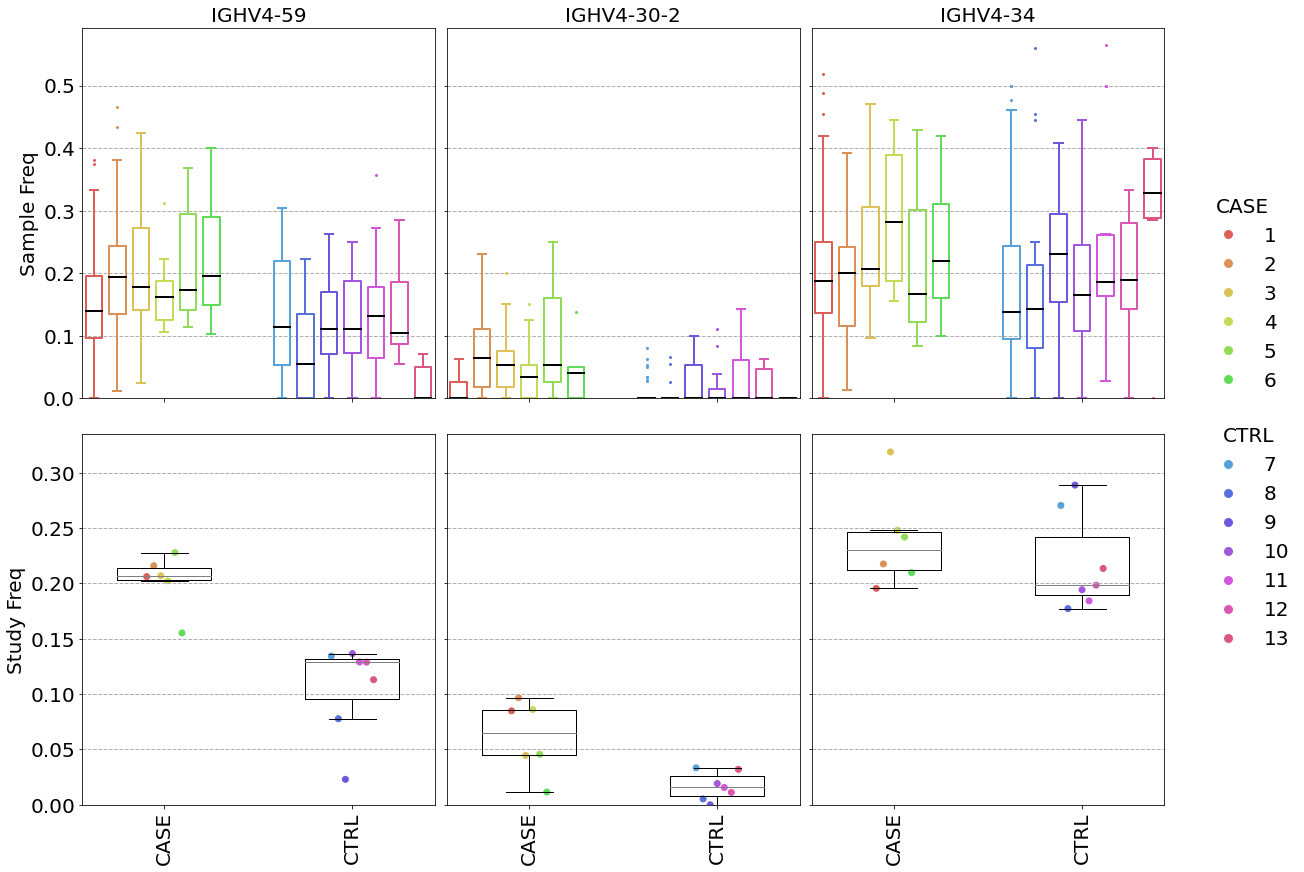

In [21]:
# The covid v_gene motifs analysis 
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from AbMetaAnalysis.EDA import get_motif_analysis, mannwhitneyu_test, count_v_gene_by_subj, load_motifs_analysis, save_motifs_analysis
from AbMetaAnalysis.EDA import get_by_subj_motif_analysis_df, get_by_study_motif_analysis_df


force_v_gene_analysis = False
covid_by_subj_v_gene_df, covid_by_study_v_gene_df, covid_by_label_v_gene_df = load_motifs_analysis(
    motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='v_gene'
)
if force_v_gene_analysis or covid_by_subj_v_gene_df is None or covid_by_study_v_gene_df is None or covid_by_label_v_gene_df is None:
    covid_by_subj_v_gene_df, covid_by_study_v_gene_df, covid_by_label_v_gene_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        count_v_gene_by_subj,
        outlier_th=3,
        ci_alpha=0.1
    )
    save_motifs_analysis(
        by_subj_motif_df=covid_by_subj_v_gene_df, 
        by_study_motif_df=covid_by_study_v_gene_df, 
        by_label_motif_df=covid_by_label_v_gene_df,
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='v_gene'
    )

covid_by_subj_ighv4_df = get_by_subj_motif_analysis_df(
    covid_by_subj_v_gene_df.loc[
        :, ('occur', filter(lambda x: x.startswith('IGHV4'), covid_by_subj_v_gene_df.columns.get_level_values(1)))
    ].loc[:, 'occur']
)
covid_by_study_ighv4_df = pd.concat(
    {'CASE': get_by_study_motif_analysis_df(covid_by_subj_ighv4_df.loc['CASE'], outlier_th=3)}, names=['label']
).append(
    pd.concat({'CTRL': get_by_study_motif_analysis_df(covid_by_subj_ighv4_df.loc['CTRL'], outlier_th=3)}, names=['label'])
)

print("mannwhitneyu v_gene usage by subject test:")
print(
    mannwhitneyu_test(
        df=covid_by_subj_ighv4_df,
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)
print("mannwhitneyu v_gene usage by study test:")
print(
    mannwhitneyu_test(
        df=covid_by_study_ighv4_df,
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)

fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(18, 12), sharex='col', sharey='row')
case_ctrl_color_diff=3
boxplot_features(
    by_subj_df=covid_by_subj_ighv4_df.loc[:, (slice(None), ['IGHV4-59', 'IGHV4-30-2', 'IGHV4-34'])],
    by_study_df=covid_by_study_ighv4_df.loc[:, (slice(None), ['IGHV4-59', 'IGHV4-30-2', 'IGHV4-34'])],
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axes,
    case_ctrl_color_diff=case_ctrl_color_diff,
    outlier_th=2.5,
    y='prop',
    ylabel="Freq"
)

case_legend = axes[0,2].legend(handles=case_handles, title='CASE', title_fontsize=20, fontsize=20, loc=(1.1, 0.0))
case_legend.get_frame().set_linewidth(0.0)
ctrl_legend = axes[1,2].legend(handles=ctrl_handles, title='CTRL', title_fontsize=20, fontsize=20, loc=(1.1, 0.4))
ctrl_legend.get_frame().set_linewidth(0.0)
    
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'v_gene_usage.pdf'))

                  pval  reject  pvals_corrected
v_family                                       
IGHV1     1.946411e-07    True     1.362487e-06
IGHV2     4.411545e-05    True     3.088082e-04
IGHV3     2.676904e-09    True     1.873833e-08
IGHV4     7.099381e-17    True     4.969567e-16
IGHV5     4.132934e-04    True     2.893054e-03
IGHV6     9.049344e-01   False     1.000000e+00
IGHV7     6.804432e-01   False     1.000000e+00


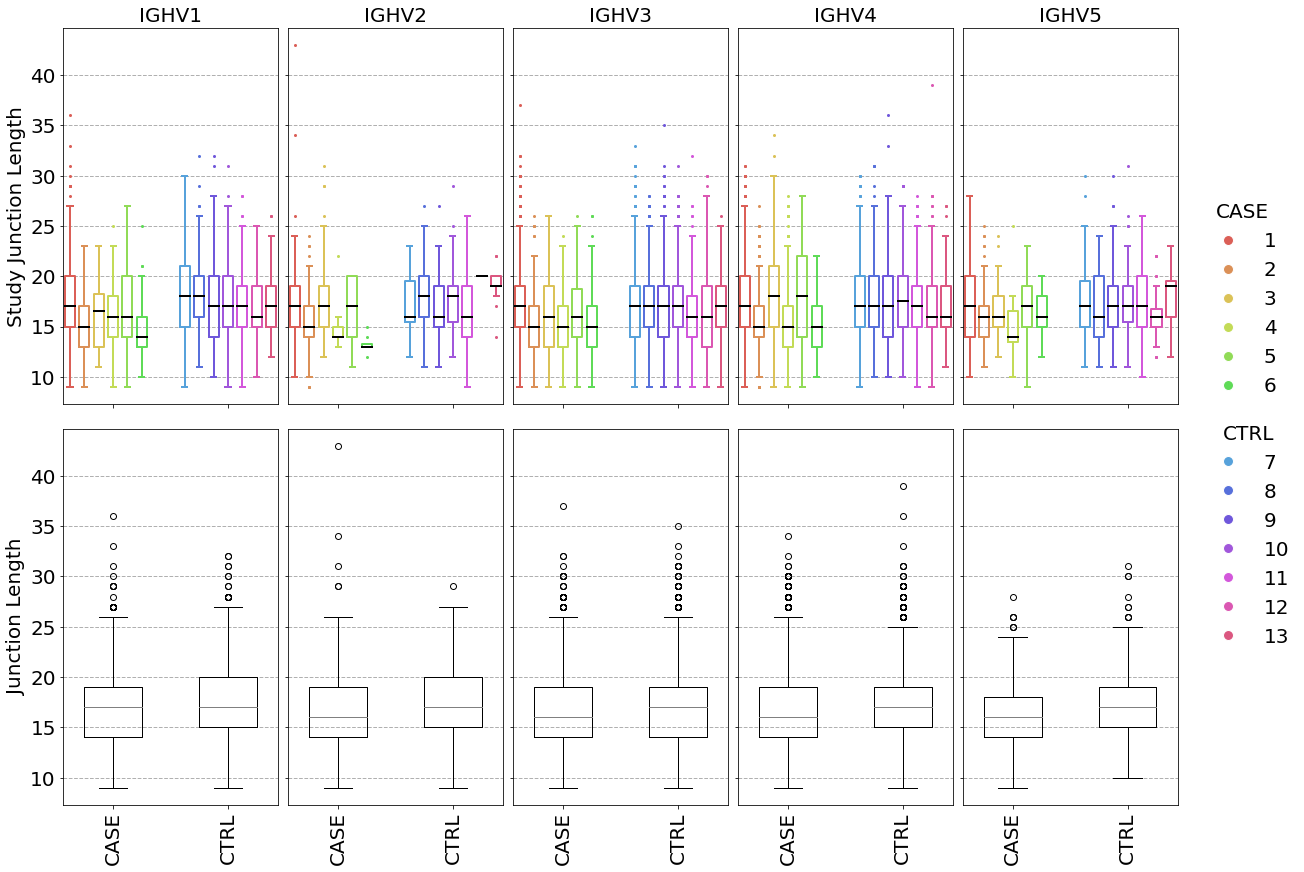

In [22]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import multinomial_proportions_confint
from statsmodels.sandbox.stats.multicomp import multipletests
from AbMetaAnalysis.Plot import boxplot_junction_aa_length
from changeo.Gene import getFamily

covid_case_v_family = covid_case_airr_seq_df.v_call_original.apply(getFamily)
covid_ctrl_v_family = covid_ctrl_airr_seq_df.v_call_original.apply(getFamily)
junction_len_by_v_family_pvalues = pd.Series(index=['IGHV1', 'IGHV2', 'IGHV3', 'IGHV4', 'IGHV5', 'IGHV6', 'IGHV7'], dtype=float, name='pval')            
for v_family in junction_len_by_v_family_pvalues.index:
    junction_len_by_v_family_pvalues[v_family] = getattr(mannwhitneyu(
        sum(
            covid_case_airr_seq_df.loc[covid_case_v_family == v_family].groupby('study_id').apply(
                lambda x: x.junction_aa_length.astype(int).tolist()
            ).to_list(), 
            []
        ),
        sum(
            covid_ctrl_airr_seq_df.loc[covid_ctrl_v_family == v_family].groupby('study_id').apply(
                lambda x: x.junction_aa_length.astype(int).tolist()
            ).to_list(), []
        ),
        alternative='two-sided'
    ), 'pvalue')
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    junction_len_by_v_family_pvalues.to_list(), 
    0.05, 
    method='bonferroni'
)
junction_len_by_v_family_pvalues = junction_len_by_v_family_pvalues.reset_index().rename(columns={'index': 'v_family'}).set_index('v_family')
junction_len_by_v_family_pvalues['reject'] = reject
junction_len_by_v_family_pvalues['pvals_corrected'] = pvals_corrected
print(junction_len_by_v_family_pvalues)

fig, axes = plt.subplots(2, 5, constrained_layout=True, figsize=(18, 12), sharex='col', sharey='row')
boxplot_junction_aa_length(
    axes=axes, 
    case_airr_seq_df=covid_case_airr_seq_df, 
    ctrl_airr_seq_df=covid_ctrl_airr_seq_df, 
    v_families=['IGHV1', 'IGHV2', 'IGHV3', 'IGHV4', 'IGHV5'], 
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    aliase2study=covid_aliase2study,
    colors=colors, 
    case_ctrl_color_diff=case_ctrl_color_diff
)

case_legend = axes[0,4].legend(handles=case_handles, title='CASE', title_fontsize=20, fontsize=20, loc=(1.1, 0))
case_legend.get_frame().set_linewidth(0.0)
ctrl_legend = axes[1,4].legend(handles=ctrl_handles, title='CTRL', title_fontsize=20, fontsize=20, loc=(1.1, 0.4))
ctrl_legend.get_frame().set_linewidth(0.0)

plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'junction_length_distribution.pdf'))

In [23]:
# The sequence motifs analysis 
from matplotlib import pyplot as plt
import seaborn as sns
from AbMetaAnalysis.EDA import get_motif_analysis, mannwhitneyu_test, count_kmers_by_subj, load_motifs_analysis, save_motifs_analysis

force_kmer_analysis = False
covid_by_subj_3mer_df, covid_by_study_3mer_df, covid_by_label_3mer_df = load_motifs_analysis(
    motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='3mer'
)

if force_kmer_analysis or covid_by_subj_3mer_df is None or covid_by_study_3mer_df is None or covid_by_label_3mer_df is None:
    covid_by_subj_3mer_df, covid_by_study_3mer_df, covid_by_label_3mer_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        lambda x: count_kmers_by_subj(x, 3),
        outlier_th=3,
        ci_alpha=0.05
    )
    save_motifs_analysis(
        by_subj_motif_df=covid_by_subj_3mer_df, 
        by_study_motif_df=covid_by_study_3mer_df, 
        by_label_motif_df=covid_by_label_3mer_df,
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='3mer'
    )
covid_by_label_3mer_df.loc[('CASE', 'sd'), :] = (covid_by_label_3mer_df.loc[('CASE', 'upr_ci'), :] - covid_by_label_3mer_df.loc[('CASE', 'prop'), :]) / 1.96
covid_by_label_3mer_df.loc[('CTRL', 'sd'), :] = (covid_by_label_3mer_df.loc[('CTRL', 'upr_ci'), :] - covid_by_label_3mer_df.loc[('CTRL', 'prop'), :]) / 1.96
covid_3mer_z_df = (
    (
        (covid_by_label_3mer_df.loc[('CASE', 'prop'), :] - covid_by_label_3mer_df.loc[('CTRL', 'prop'), :])
    ) / (
        (covid_by_label_3mer_df.loc[('CASE', 'sd'), :]**2 + covid_by_label_3mer_df.loc[('CTRL', 'sd'), :]**2).apply(math.sqrt)
    )
)
    
print("***3-mers with increased usage in CASE - 95% confidence level:***")
print(covid_3mer_z_df.loc[covid_3mer_z_df >= 1.96].index)
print("***3-mers with increased usage in CTRL - 95% confidence level:***")
print(covid_3mer_z_df.loc[covid_3mer_z_df <= -1.96].index)

print("***mannwhitneyu 3-mers freq by subject test:***")
for kmer in covid_3mer_z_df.loc[covid_3mer_z_df >= 1.96].index:
    print(
        mannwhitneyu_test(
            df=covid_by_subj_3mer_df.loc[:, (slice(None), [kmer])],
            confidence_th=0.05,
            alternative='greater',
            adjustment_method='holm-sidak',
            y='prop'
        )
    )
print("**mannwhitneyu 3-mers freq by study test:***")
for kmer in covid_3mer_z_df.loc[covid_3mer_z_df >= 1.96].index:
    print(
        mannwhitneyu_test(
            df=covid_by_study_3mer_df.loc[:, (slice(None), [kmer])],
            confidence_th=0.05,
            alternative='greater',
            adjustment_method='holm-sidak',
            y='prop'
        )
    )

/home/boaz/.local/lib/python3.8/site-packages/AbMetaAnalysis/EDA.py:292: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  by_subj_motif_df = pd.read_csv(by_subj_motif_df_file_path, header=[0, 1])


***3-mers with increased usage in CASE - 95% confidence level:***
Index(['FDP', 'FGV', 'GVV', 'GWF', 'IFG', 'MDV', 'NWF', 'TIF', 'VVI', 'WFD',
       'YMD', 'YYM'],
      dtype='object')
***3-mers with increased usage in CTRL - 95% confidence level:***
Index(['CSG', 'GSC'], dtype='object')
***mannwhitneyu 3-mers freq by subject test:***
    pvalue pvalue_corrected reject
FDP    0.0              0.0   True
       pvalue pvalue_corrected reject
FGV  0.000015         0.000015   True
       pvalue pvalue_corrected reject
GVV  0.000109         0.000109   True
       pvalue pvalue_corrected reject
GWF  0.001285         0.001285   True
       pvalue pvalue_corrected reject
IFG  0.000075         0.000075   True
       pvalue pvalue_corrected reject
MDV  0.002344         0.002344   True
       pvalue pvalue_corrected reject
NWF  0.000027         0.000027   True
       pvalue pvalue_corrected reject
TIF  0.000003         0.000003   True
      pvalue pvalue_corrected reject
VVI  0.00001          

***mannwhitneyu 5-mers freq by subject test:***
         pvalue pvalue_corrected reject
NWFDP  0.000002         0.000003   True
GWFDP  0.000011         0.000011   True
***mannwhitneyu IGHJ5*02 freq by study test:***
         pvalue pvalue_corrected reject
GWFDP  0.002331         0.004657   True
NWFDP  0.068765         0.068765  False


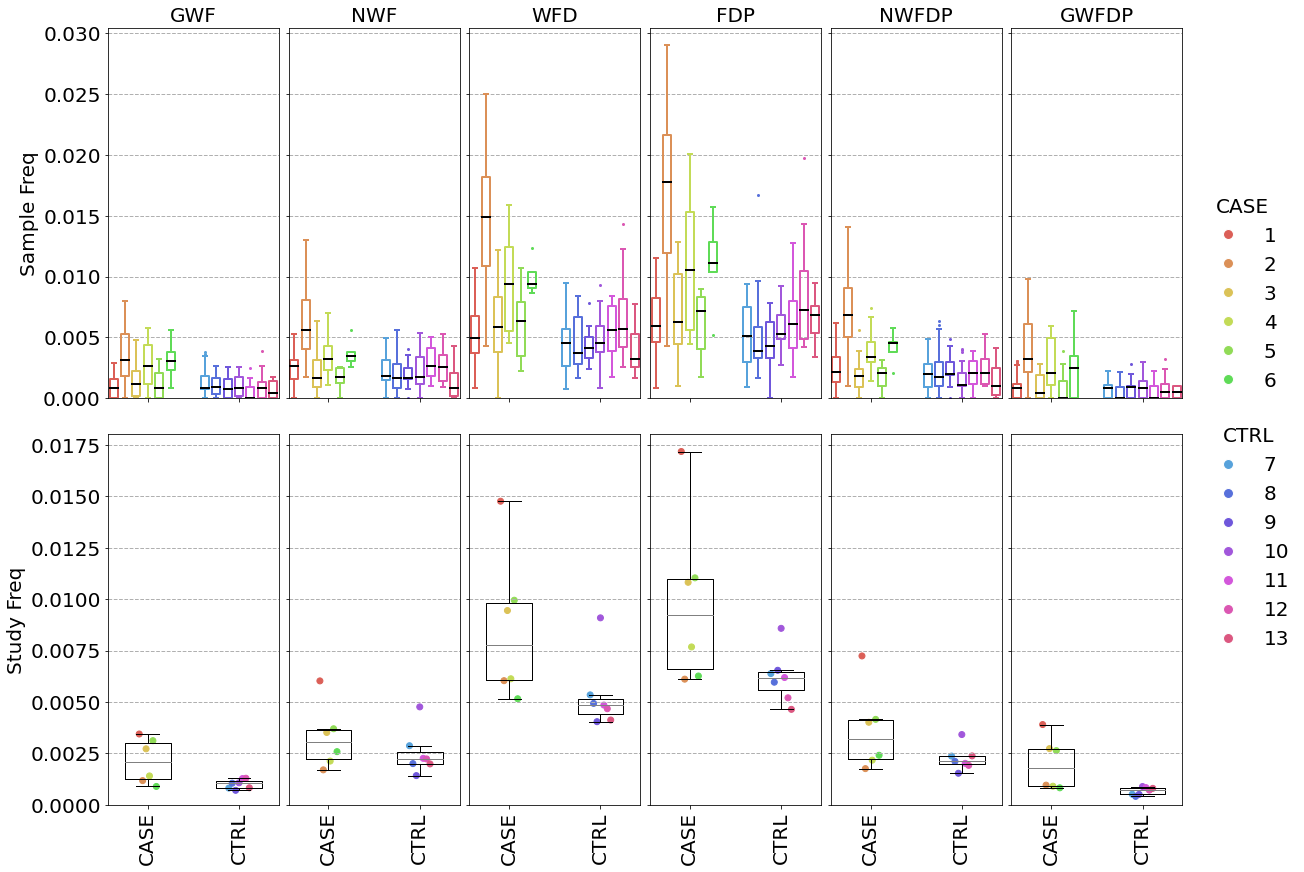

In [24]:
covid_by_subj_nwfdp_df, covid_by_study_nwfdp_df, covid_by_label_nwfdp_df = load_motifs_analysis(
    motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'),
    base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
    motif='nwfdp'
)
force_kmer_analysis=False
if force_kmer_analysis or covid_by_subj_nwfdp_df is None or covid_by_study_nwfdp_df is None or covid_by_label_nwfdp_df is None:

    covid_by_subj_5mer_df, covid_by_study_5mer_df, covid_by_label_5mer_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        lambda x: count_kmers_by_subj(x, 5),
        outlier_th=3
    )
    save_motifs_analysis(
        by_subj_motif_df=pd.concat(
            [covid_by_subj_3mer_df.loc[:, (slice(None), ['GWF', 'NWF', 'WFD', 'FDP'])], covid_by_subj_5mer_df.loc[:, (slice(None), ['NWFDP', 'GWFDP'])]], axis=1
        ),
        by_study_motif_df=pd.concat(
            [covid_by_study_3mer_df.loc[:, (slice(None), ['GWF', 'NWF', 'WFD', 'FDP'])], covid_by_study_5mer_df.loc[:, (slice(None), ['NWFDP', 'GWFDP'])]], axis=1
        ), 
        by_label_motif_df=pd.concat(
            [covid_by_label_3mer_df.loc[:, ['GWF', 'NWF', 'WFD', 'FDP']], covid_by_label_5mer_df.loc[:, ['NWFDP', 'GWFDP']]], axis=1
        ), 
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
        base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
        motif='nwfdp'
    )
    covid_by_subj_nwfdp_df, covid_by_study_nwfdp_df, covid_by_label_nwfdp_df = load_motifs_analysis(
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='nwfdp'
    )
    del covid_by_subj_5mer_df, covid_by_study_5mer_df, covid_by_label_5mer_df

print("***mannwhitneyu 5-mers freq by subject test:***") 
print(
    mannwhitneyu_test(
        df=covid_by_subj_nwfdp_df.loc[:, (slice(None), ['NWFDP', 'GWFDP'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)
print("***mannwhitneyu IGHJ5*02 freq by study test:***") 
print(
    mannwhitneyu_test(
        df=covid_by_study_nwfdp_df.loc[:, (slice(None), ['NWFDP', 'GWFDP'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)  

fig, axes = plt.subplots(2, 6, constrained_layout=True, figsize=(18, 12), sharex='col', sharey='row')
case_ctrl_color_diff=3
colors = sns.color_palette("hls", len(covid_by_study_v_gene_df) + case_ctrl_color_diff)
boxplot_features(
    by_subj_df=covid_by_subj_nwfdp_df,
    by_study_df=covid_by_study_nwfdp_df,
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axes,
    case_ctrl_color_diff=case_ctrl_color_diff,
    outlier_th=2.5,
    y='prop',
    ylabel="Freq"
)

case_legend = axes[0,5].legend(handles=case_handles, title='CASE', title_fontsize=20, fontsize=20, loc=(1.1, 0))
case_legend.get_frame().set_linewidth(0.0)
ctrl_legend = axes[1,5].legend(handles=ctrl_handles, title='CTRL', title_fontsize=20, fontsize=20, loc=(1.1, 0.4))
ctrl_legend.get_frame().set_linewidth(0.0)
    
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'nwfdp_junction_motif.pdf'))

***mannwhitneyu 5-mers freq by subject test:***
         pvalue pvalue_corrected reject
YYMDV  0.015825         0.015825   True
***mannwhitneyu 5-mers freq by study test:***
         pvalue pvalue_corrected reject
YYMDV  0.025641         0.025641   True


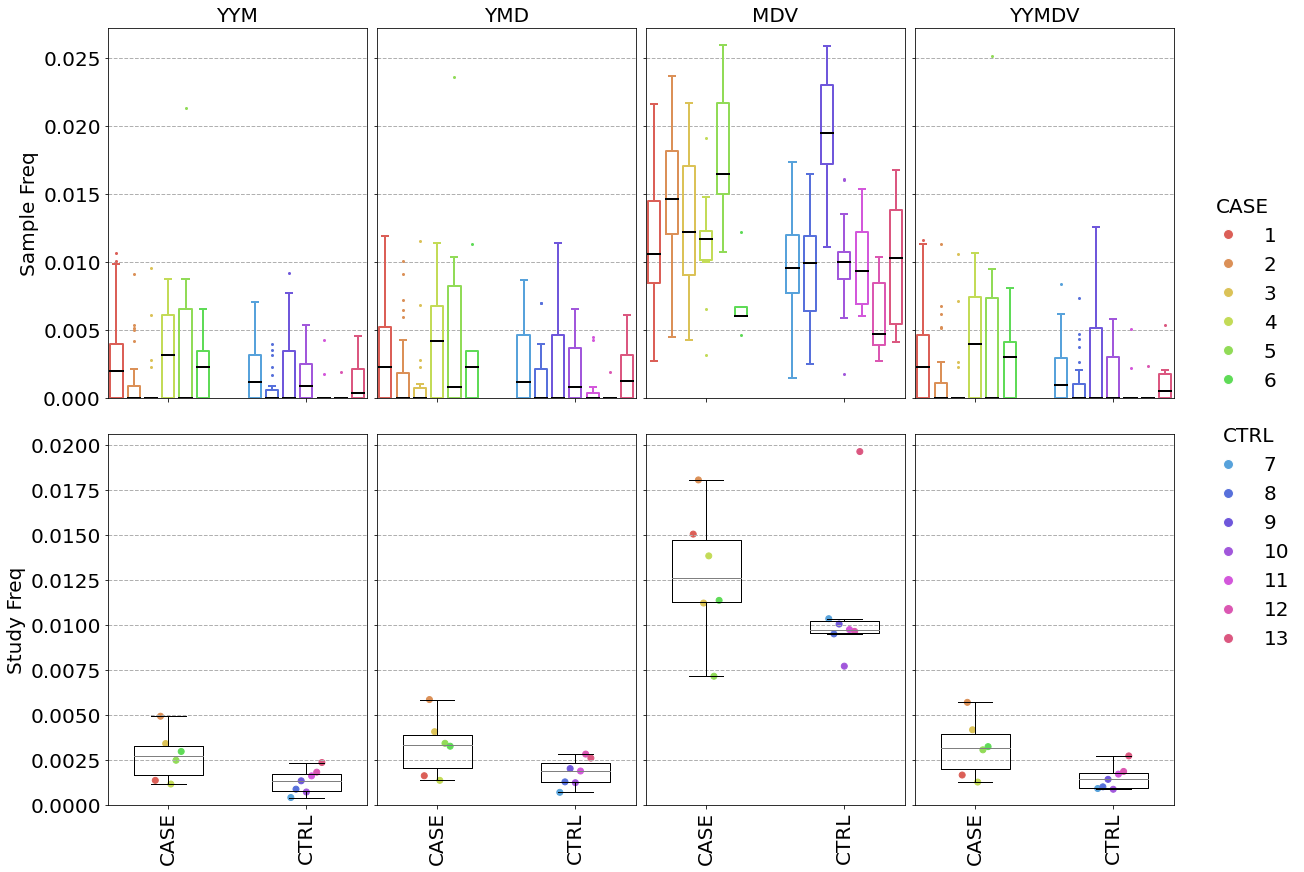

In [29]:
covid_by_subj_yymdv_df, covid_by_study_yymdv_df, covid_by_label_yymdv_df = load_motifs_analysis(
    motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='yymdv'
)
force_kmer_analysis=False
if force_kmer_analysis or covid_by_subj_yymdv_df is None or covid_by_study_yymdv_df is None or covid_by_label_yymdv_df is None:
    covid_by_subj_5mer_df, covid_by_study_5mer_df, covid_by_label_5mer_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        lambda x: count_kmers_by_subj(x, 5),
        outlier_th=3
    )
    save_motifs_analysis(
        by_subj_motif_df=pd.concat(
            [covid_by_subj_3mer_df.loc[:, (slice(None), ['YYM', 'YMD', 'MDV'])], covid_by_subj_5mer_df.loc[:, (slice(None), ['YYMDV'])]], axis=1
        ),
        by_study_motif_df=pd.concat(
            [covid_by_study_3mer_df.loc[:, (slice(None), ['YYM', 'YMD', 'MDV'])], covid_by_study_5mer_df.loc[:, (slice(None), ['YYMDV'])]], axis=1
        ), 
        by_label_motif_df=pd.concat(
            [covid_by_label_3mer_df.loc[:, ['YYM', 'YMD', 'MDV']], covid_by_label_5mer_df.loc[:, ['YYMDV']]], axis=1
        ), 
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
        base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
        motif='yymdv'
    )
    covid_by_subj_yymdv_df, covid_by_study_yymdv_df, covid_by_label_yymdv_df = load_motifs_analysis(
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', motif='yymdv'
    )


print("***mannwhitneyu 5-mers freq by subject test:***") 
print(
    mannwhitneyu_test(
        df=covid_by_subj_yymdv_df.loc[:, (slice(None), ['YYMDV'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)
print("***mannwhitneyu 5-mers freq by study test:***") 
print(
    mannwhitneyu_test(
        df=covid_by_study_yymdv_df.loc[:, (slice(None), ['YYMDV'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)

fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(18, 12), sharex='col', sharey='row')
case_ctrl_color_diff=3
colors = sns.color_palette("hls", len(covid_by_study_v_gene_df) + case_ctrl_color_diff)
boxplot_features(
    by_subj_df=covid_by_subj_yymdv_df,
    by_study_df=covid_by_study_yymdv_df,
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axes,
    case_ctrl_color_diff=case_ctrl_color_diff,
    outlier_th=2.5,
    y='prop',
    ylabel="Freq"
)

case_legend = axes[0,3].legend(handles=case_handles, title='CASE', title_fontsize=20, fontsize=20, loc=(1.1, 0))
case_legend.get_frame().set_linewidth(0.0)
ctrl_legend = axes[1,3].legend(handles=ctrl_handles, title='CTRL', title_fontsize=20, fontsize=20, loc=(1.1, 0.4))
ctrl_legend.get_frame().set_linewidth(0.0)
    
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'yymdv_junction_motif.pdf'), bbox_inches='tight')

***mannwhitneyu 7-mers freq by subject test:***
           pvalue pvalue_corrected reject
ITIFGVV  0.000001         0.000001   True
           pvalue pvalue_corrected reject
TIFGVVI  0.000652         0.000652   True
          pvalue pvalue_corrected reject
IFGVVII  0.01529          0.01529   True
***mannwhitneyu 4-mers freq by study test:***
           pvalue pvalue_corrected reject
ITIFGVV  0.008103         0.008103   True
           pvalue pvalue_corrected reject
TIFGVVI  0.016553         0.016553   True
           pvalue pvalue_corrected reject
IFGVVII  0.009248         0.009248   True


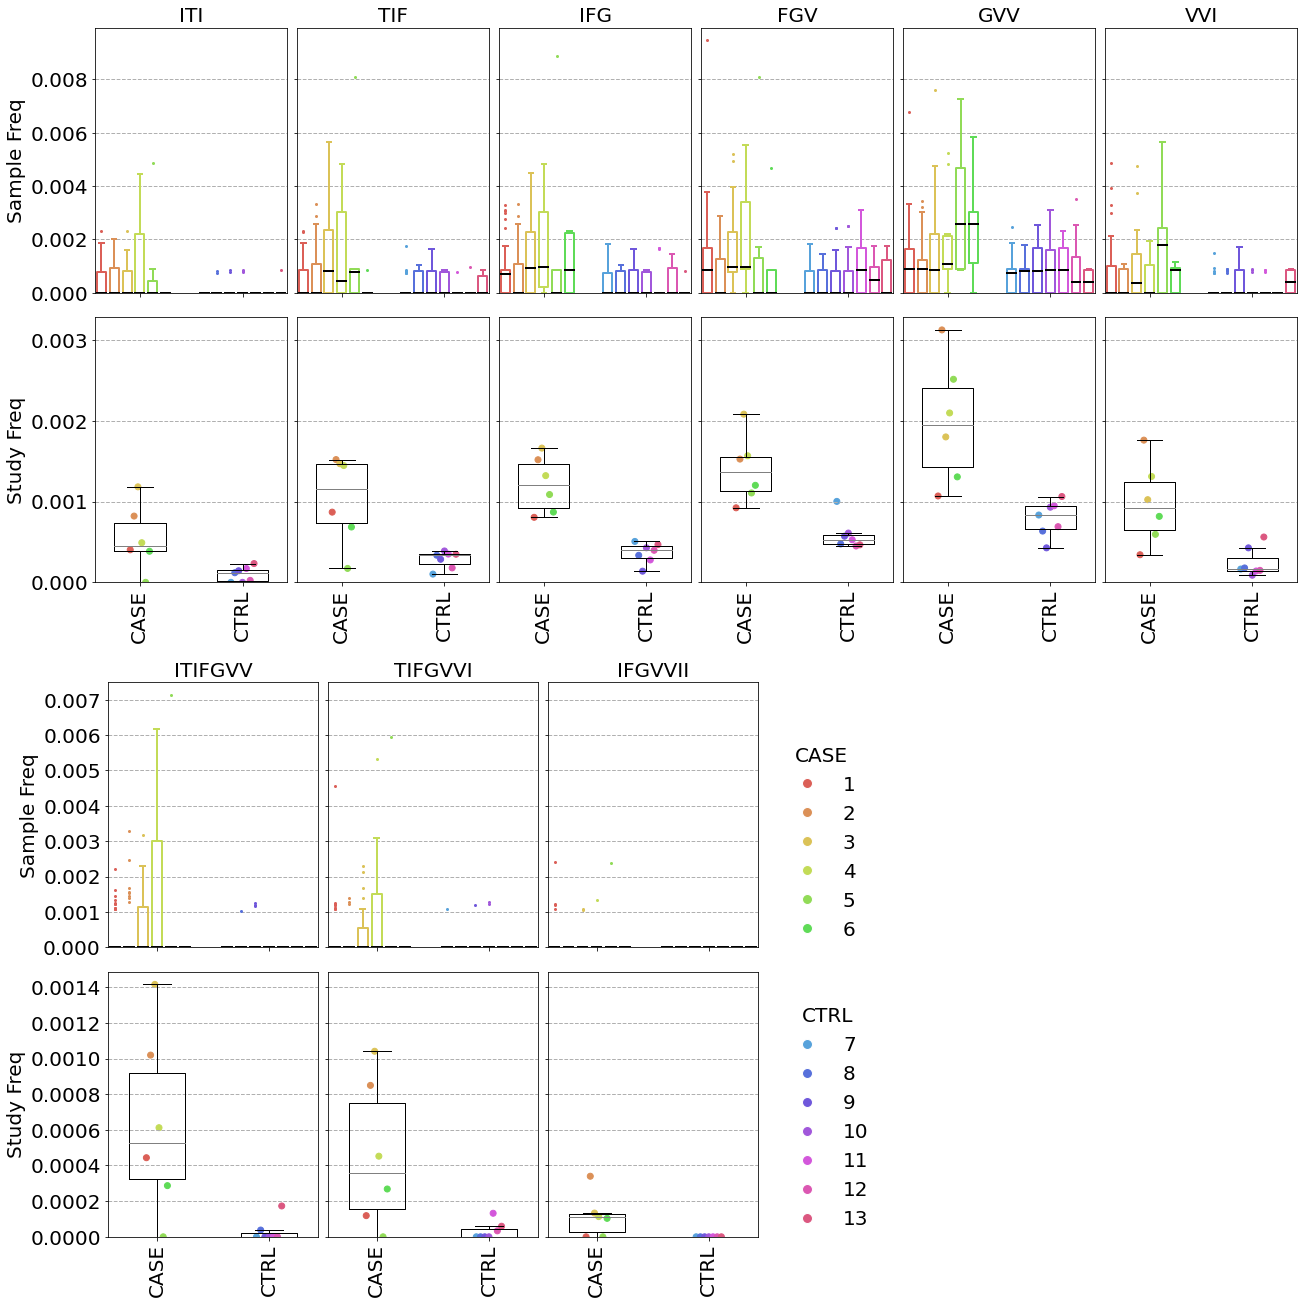

In [31]:
covid_by_subj_itifgvvii_df, covid_by_study_itifgvvii_df, covid_by_label_itifgvvii_df = load_motifs_analysis(
    motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
    base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
    motif='itifgvvii'
)

if force_kmer_analysis or covid_by_subj_itifgvvii_df is None or covid_by_study_itifgvvii_df is None or covid_by_label_itifgvvii_df is None:

    covid_by_subj_7mer_df, covid_by_study_7mer_df, covid_by_label_7mer_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        lambda x: count_kmers_by_subj(x, 7),
        outlier_th=3,
        ci_alpha=0.1
    )
    save_motifs_analysis(
        by_subj_motif_df=pd.concat(
            [
                covid_by_subj_3mer_df.loc[:, (slice(None), ['ITI', 'TIF', 'IFG', 'FGV', 'GVV', 'VVI'])], 
                covid_by_subj_7mer_df.loc[:, (slice(None), ['ITIFGVV', 'TIFGVVI', 'IFGVVII'])]
            ], axis=1
        ),
        by_study_motif_df=pd.concat(
            [
                covid_by_study_3mer_df.loc[:, (slice(None), ['ITI', 'TIF', 'IFG', 'FGV', 'GVV', 'VVI'])], 
                covid_by_study_7mer_df.loc[:, (slice(None), ['ITIFGVV', 'TIFGVVI', 'IFGVVII'])]
            ], axis=1
        ), 
        by_label_motif_df=pd.concat(
            [
                covid_by_label_3mer_df.loc[:, ['ITI', 'TIF', 'IFG', 'FGV', 'GVV', 'VVI']], 
                covid_by_label_7mer_df.loc[:, ['ITIFGVV', 'TIFGVVI', 'IFGVVII']]
            ], axis=1
        ), 
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
        base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
        motif='itifgvvii'
    )
    covid_by_subj_itifgvvii_df, covid_by_study_itifgvvii_df, covid_by_label_itifgvvii_df = load_motifs_analysis(
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
        base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
        motif='itifgvvii'
    )
    del covid_by_subj_7mer_df, covid_by_study_7mer_df, covid_by_label_7mer_df

print("***mannwhitneyu 7-mers freq by subject test:***")
for kmer in ['ITIFGVV', 'TIFGVVI', 'IFGVVII']:
    print(
        mannwhitneyu_test(
            df=covid_by_subj_itifgvvii_df.loc[:, (slice(None), [kmer])],
            confidence_th=0.05,
            alternative='greater',
            adjustment_method='holm-sidak',
            y='prop'
        )
)
print("***mannwhitneyu 4-mers freq by study test:***")
for kmer in ['ITIFGVV', 'TIFGVVI', 'IFGVVII']:
    print(
        mannwhitneyu_test(
            df=covid_by_study_itifgvvii_df.loc[:, (slice(None), [kmer])],
            confidence_th=0.05,
            alternative='greater',
            adjustment_method='holm-sidak',
            y='prop'
        )
    )

fig, axs = plt.subplots(2, 6, constrained_layout=True, figsize=(18, 18))
gridspec = axs[0, 0].get_subplotspec().get_gridspec()
for a in axs.flatten():
    a.remove()
subfig = fig.add_subfigure(gridspec[0, :6])
axsUp = subfig.subplots(2, 6, sharex="col", sharey="row")
subfig = fig.add_subfigure(gridspec[1, :6])
axsBottom = subfig.subplots(2, 5, sharex="col", sharey="row")
for a in axsBottom.flatten()[[3, 4, 8, 9]]:
    a.remove()

boxplot_features(
    by_subj_df=covid_by_subj_itifgvvii_df.loc[:, (slice(None), ['ITI', 'TIF', 'IFG', 'FGV', 'GVV', 'VVI'])],
    by_study_df=covid_by_study_itifgvvii_df.loc[:, (slice(None), ['ITI', 'TIF', 'IFG', 'FGV', 'GVV', 'VVI'])],
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axsUp,
    case_ctrl_color_diff=case_ctrl_color_diff,
    outlier_th=2.5,
    y='prop',
    ylabel="Freq"
)
boxplot_features(
    by_subj_df=covid_by_subj_itifgvvii_df.loc[:, (slice(None), ['ITIFGVV', 'TIFGVVI', 'IFGVVII'])],
    by_study_df=covid_by_study_itifgvvii_df.loc[:, (slice(None), ['ITIFGVV', 'TIFGVVI', 'IFGVVII'])],
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axsBottom,
    case_ctrl_color_diff=case_ctrl_color_diff,
    outlier_th=3,
    y='prop',
    ylabel="Freq"
)

case_legend = axsBottom[0,2].legend(handles=case_handles, title='CASE', title_fontsize=20, fontsize=20, loc=(1.1, 0))
case_legend.get_frame().set_linewidth(0.0)
ctrl_legend = axsBottom[1,2].legend(handles=ctrl_handles, title='CTRL', title_fontsize=20, fontsize=20, loc=(1.1, 0))
ctrl_legend.get_frame().set_linewidth(0.0)

plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'itifgvvii_junction_motif.pdf'), bbox_inches='tight')

***mannwhitneyu j genes usage by subject test:***
            pvalue pvalue_corrected reject
IGHJ5*02  0.000019         0.000037   True
IGHJ6*03  0.106216         0.106216  False
***mannwhitneyu j genes usage by study test:***
            pvalue pvalue_corrected reject
IGHJ6*03  0.068765         0.132801  False
IGHJ5*02  0.222611         0.222611  False
***mannwhitneyu d genes usage by subject test:***
              pvalue pvalue_corrected reject
IGHD3-3*01  0.024697         0.024697   True
***mannwhitneyu d genes usage by study test:***
              pvalue pvalue_corrected reject
IGHD3-3*01  0.365385         0.365385  False


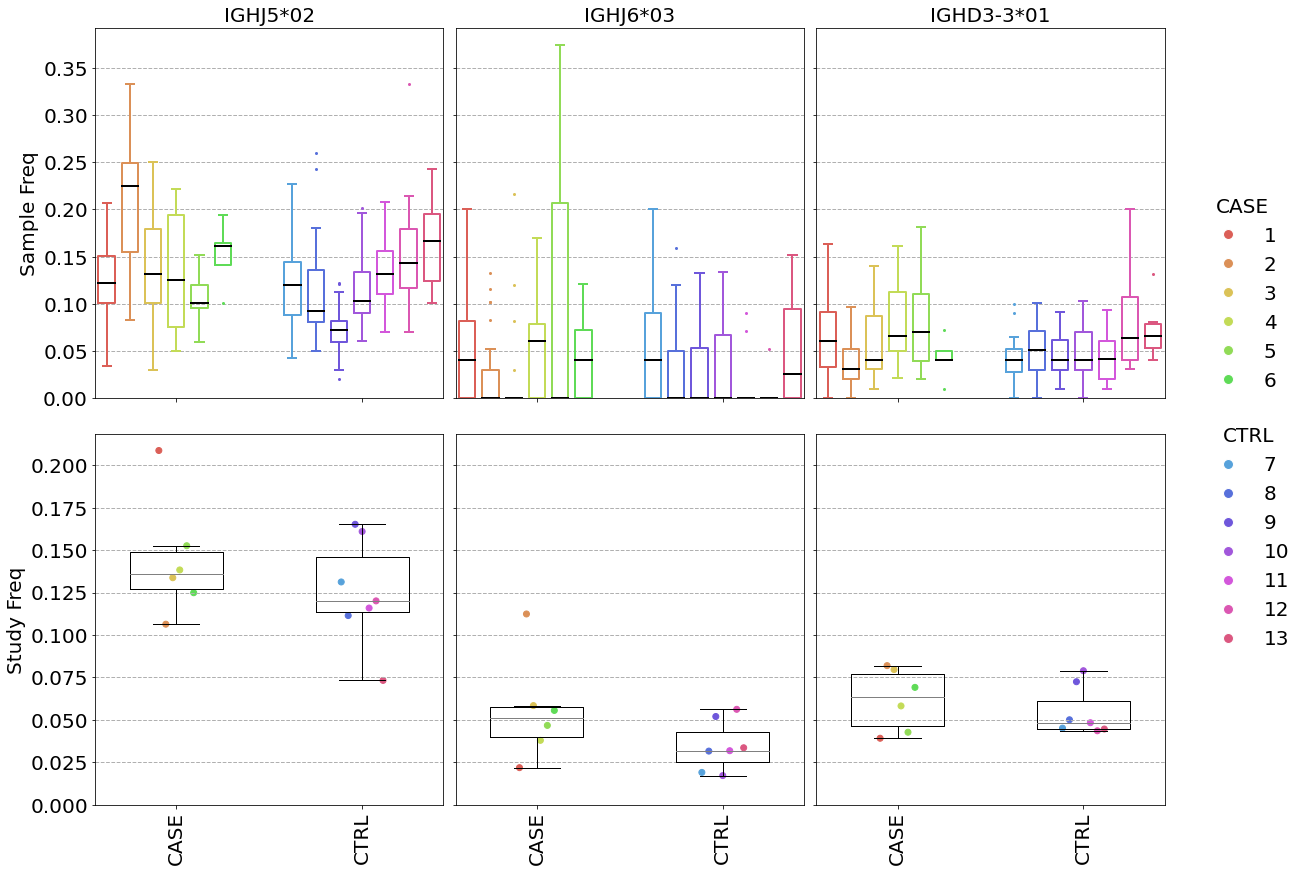

In [32]:
from AbMetaAnalysis.EDA import count_j_allele_by_subj, count_d_allele_by_subj
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

covid_by_subj_j_allele_df, covid_by_study_j_allele_df, covid_by_label_j_allele_df = get_motif_analysis(
    covid_case_airr_seq_df,
    covid_ctrl_airr_seq_df,
    count_j_allele_by_subj,
    outlier_th=3
)

print("***mannwhitneyu j genes usage by subject test:***")
print(
    mannwhitneyu_test(
        df=covid_by_subj_j_allele_df.loc[:, (slice(None), ['IGHJ5*02', 'IGHJ6*03'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)

print("***mannwhitneyu j genes usage by study test:***")
print(
    mannwhitneyu_test(
        df=covid_by_study_j_allele_df.loc[:, (slice(None), ['IGHJ5*02', 'IGHJ6*03'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)

covid_by_subj_d_allele_df, covid_by_study_d_allele_df, covid_by_label_d_allele_df = get_motif_analysis(
    covid_case_airr_seq_df,
    covid_ctrl_airr_seq_df,
    count_d_allele_by_subj,
    outlier_th=3
)


print("***mannwhitneyu d genes usage by subject test:***")
print(
    mannwhitneyu_test(
        df=covid_by_subj_d_allele_df.loc[:, (slice(None), ['IGHD3-3*01'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)


print("***mannwhitneyu d genes usage by study test:***")
print(
    mannwhitneyu_test(
        df=covid_by_study_d_allele_df.loc[:, (slice(None), ['IGHD3-3*01'])],
        confidence_th=0.05,
        alternative='greater',
        adjustment_method='holm-sidak',
        y='prop'
    )
)


fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(18, 12), sharex='col', sharey='row')
case_ctrl_color_diff=3
colors = sns.color_palette("hls", len(covid_by_study_v_gene_df) + case_ctrl_color_diff)
boxplot_features(
    by_subj_df=pd.concat(
        [covid_by_subj_j_allele_df.loc[:, (slice(None), ['IGHJ5*02', 'IGHJ6*03'])], covid_by_subj_d_allele_df.loc[:, (slice(None), ['IGHD3-3*01'])]], axis=1
    ),
    by_study_df=pd.concat(
        [covid_by_study_j_allele_df.loc[:, (slice(None), ['IGHJ5*02', 'IGHJ6*03'])], covid_by_study_d_allele_df.loc[:, (slice(None), ['IGHD3-3*01'])]], axis=1
    ),
    aliase2study=covid_aliase2study,
    case_aliases=covid_case_aliases,
    ctrl_aliases=covid_ctrl_aliases,
    colors=colors,
    axes=axes,
    case_ctrl_color_diff=case_ctrl_color_diff,
    outlier_th=2.5,
    y='prop',
    ylabel="Freq"
)

case_legend = axes[0,2].legend(handles=case_handles, title='CASE', title_fontsize=20, fontsize=20, loc=(1.1, 0))
case_legend.get_frame().set_linewidth(0.0)
ctrl_legend = axes[1,2].legend(handles=ctrl_handles, title='CTRL', title_fontsize=20, fontsize=20, loc=(1.1, 0.4))
ctrl_legend.get_frame().set_linewidth(0.0)
    
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'motif_alleles_usage.pdf'), bbox_inches='tight')

<ipython-input-33-5d02f62bc494>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  covabdab_airr_seq_df['v_gene'] = covabdab_airr_seq_df.v_call.str.replace(' \(Human\)', '').str.strip()


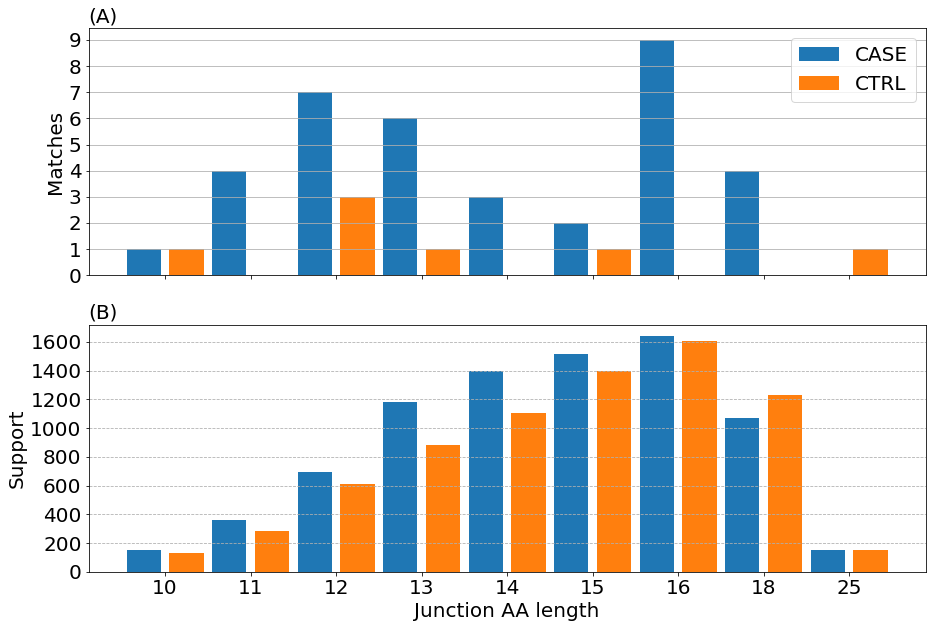

In [33]:
from AbMetaAnalysis.EDA import compare_to_reference_df
from AbMetaAnalysis.Plot import plot_compare_to_reference_cdr3_df

covabdab_airr_seq_df = pd.read_csv(os.path.join(input_dir, 'data_files', 'Cov-AbDab', 'Cov-AbDab.tsv'), sep='\t')
covabdab_airr_seq_df = covabdab_airr_seq_df.loc[covabdab_airr_seq_df.v_call.str.find("Human") != -1]
covabdab_airr_seq_df['v_gene'] = covabdab_airr_seq_df.v_call.str.replace(' \(Human\)', '').str.strip()
covabdab_airr_seq_df['v_family'] = covabdab_airr_seq_df.v_gene.apply(getFamily)
covabdab_airr_seq_df.v_family.value_counts(normalize=True)
covabdab_airr_seq_df = covabdab_airr_seq_df.loc[covabdab_airr_seq_df.cdr3_aa.str.len() >= 7]
covabdab_airr_seq_df['junction_aa'] = 'C' + covabdab_airr_seq_df.cdr3_aa + 'W'
covabdab_airr_seq_df = covabdab_airr_seq_df.groupby(['v_gene', 'junction_aa']).apply(lambda x: x.iloc[0])
min_dist_df, case_matched_sequences, ctrl_matched_sequences = compare_to_reference_df(
    case_airr_seq_df=covid_case_airr_seq_df,
    ctrl_airr_seq_df=covid_ctrl_airr_seq_df,
    ref_airr_seq_df=covabdab_airr_seq_df,
    min_dist_th=0.1
)

plot_compare_to_reference_cdr3_df(min_dist_df)
plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'covabdab_junction_compare.pdf'))

In [34]:
# The sequence motifs analysis 
from matplotlib import pyplot as plt
import seaborn as sns
from AbMetaAnalysis.EDA import get_motif_analysis, count_v_gene_by_subj, count_kmers_by_subj, load_motifs_analysis, save_motifs_analysis
from AbMetaAnalysis.Utilities import load_sampled_airr_seq_df
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

force_features_construction = False
covid_by_subj_features_df, __, __ = load_motifs_analysis(
    motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
    base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
    motif='features'
)
    
if force_features_construction or covid_by_subj_features_df is None:

    cluster_sampling_covid_airr_seq_df = load_sampled_airr_seq_df(
        file_path=os.path.join(
            output_dir, 'covid_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
        ),
        labels=covid_labels.append(covid_test_labels),
        v_call_field="v_call_original",
        group_mode="family"
    )
    covid_case_airr_seq_df = cluster_sampling_covid_airr_seq_df.reset_index().set_index(['study_id', 'subject_id'], drop=False).loc[
        covid_labels[covid_labels].append(covid_test_labels[covid_test_labels]).index
    ].set_index('id')
    covid_ctrl_airr_seq_df = cluster_sampling_covid_airr_seq_df.reset_index().set_index(['study_id', 'subject_id'], drop=False).loc[
        covid_labels[~covid_labels].append(covid_test_labels[~covid_test_labels]).index
    ].set_index('id')


    covid_by_subj_5mer_df, covid_by_study_5mer_df, covid_by_label_5mer_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        lambda x: count_kmers_by_subj(x, 5),
        outlier_th=3,
        ci_alpha=0.1
    )
    covid_by_subj_7mer_df, covid_by_study_7mer_df, covid_by_label_7mer_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        lambda x: count_kmers_by_subj(x, 7),
        outlier_th=3,
        ci_alpha=0.1
    )
    covid_by_subj_v_gene_df, covid_by_study_v_gene_df, covid_by_label_v_gene_df = get_motif_analysis(
        covid_case_airr_seq_df,
        covid_ctrl_airr_seq_df,
        count_v_gene_by_subj,
        outlier_th=3,
        ci_alpha=0.1
    )
    save_motifs_analysis(
        by_subj_motif_df=pd.concat(
            [
                covid_by_subj_v_gene_df.loc[:, (slice(None), ['IGHV4-34', 'IGHV4-59', 'IGHV4-30-2'])],
                covid_by_subj_5mer_df.loc[:, (slice(None), ['GWFDP', 'NWFDP', 'YYMDV'])],
                covid_by_subj_7mer_df.loc[:, (slice(None), ['ITIFGVV', 'TIFGVVI', 'IFGVVII'])]
            ], axis=1
        ),
        by_study_motif_df=pd.concat(
            [
                covid_by_study_v_gene_df.loc[:, (slice(None), ['IGHV4-34', 'IGHV4-59', 'IGHV4-30-2'])],
                covid_by_study_5mer_df.loc[:, (slice(None), ['GWFDP', 'NWFDP' 'YYMDV'])],
                covid_by_study_7mer_df.loc[:, (slice(None), ['ITIFGVV', 'TIFGVVI', 'IFGVVII'])]
            ], axis=1
        ), 
        by_label_motif_df=pd.concat(
            [
                covid_by_label_v_gene_df.loc[:, ['IGHV4-34', 'IGHV4-59', 'IGHV4-30-2']],
                covid_by_label_5mer_df.loc[:, ['GWFDP', 'NWFDP' 'YYMDV']],
                covid_by_label_7mer_df.loc[:, ['ITIFGVV', 'TIFGVVI', 'IFGVVII']]
            ], axis=1
        ), 
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
        base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
        motif='features'
    )
    covid_by_subj_features_df, __, __ = load_motifs_analysis(
        motifs_dir=os.path.join(output_dir, 'covid_output', 'motifs'), 
        base_name='top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1', 
        motif='features'
    )

motifs_train_feature_table = covid_by_subj_features_df.loc['CASE', :].append(
    covid_by_subj_features_df.loc['CTRL', :]
).loc[covid_labels.index, 'prop']
motifs_test_feature_table = covid_by_subj_features_df.loc['CASE', :].append(
    covid_by_subj_features_df.loc['CTRL', :]
).loc[covid_test_labels.index, 'prop']
lg = LogisticRegression(random_state=42)
for junc_motif in ['ITIFGVV', 'TIFGVVI', 'IFGVVII', 'GWFDP', 'NWFDP', 'YYMDV']:
    lg.fit(motifs_train_feature_table.loc[:, [junc_motif]], covid_labels)
    print(
        'classification using junction motif {}: train={}, test={}'.format(
            junc_motif,
            f'{accuracy_score(covid_labels, lg.predict(motifs_train_feature_table.loc[:, [junc_motif]])):.02}',
            f'{accuracy_score(covid_test_labels, lg.predict(motifs_test_feature_table.loc[:, [junc_motif]])):.02}'
        )
    )
for gene_motif in ['IGHV4-34', 'IGHV4-59', 'IGHV4-30-2']:
    lg.fit(motifs_train_feature_table.loc[:, [gene_motif]], covid_labels)
    print(
        'classification using gene motif {}: train={}, test={}'.format(
            gene_motif,
            f'{accuracy_score(covid_labels, lg.predict(motifs_train_feature_table.loc[:, [gene_motif]])):.02}',
            f'{accuracy_score(covid_test_labels, lg.predict(motifs_test_feature_table.loc[:, [gene_motif]])):.02}'
        )
    )
    
scaler = MinMaxScaler().fit(motifs_train_feature_table)
lg.fit(scaler.transform(motifs_train_feature_table), covid_labels)
print(
    'classification using all gene and junction motifs: train={}, test={}'.format(
        f'{accuracy_score(covid_labels, lg.predict(scaler.transform(motifs_train_feature_table))):.02}',
        f'{accuracy_score(covid_test_labels, lg.predict(scaler.transform(motifs_test_feature_table))):.02}'
    )
)

classification using junction motif ITIFGVV: train=0.6, test=0.62
classification using junction motif TIFGVVI: train=0.56, test=0.54
classification using junction motif IFGVVII: train=0.53, test=0.5
classification using junction motif GWFDP: train=0.64, test=0.52
classification using junction motif NWFDP: train=0.62, test=0.37
classification using junction motif YYMDV: train=0.56, test=0.6
classification using gene motif IGHV4-34: train=0.68, test=0.62
classification using gene motif IGHV4-59: train=0.7, test=0.38
classification using gene motif IGHV4-30-2: train=0.64, test=0.52
classification using all gene and junction motifs: train=0.75, test=0.54


<ipython-input-34-8c6d9848ddb6>:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  motifs_train_feature_table = covid_by_subj_features_df.loc['CASE', :].append(
<ipython-input-34-8c6d9848ddb6>:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  motifs_test_feature_table = covid_by_subj_features_df.loc['CASE', :].append(


***study_id IR-Binder-000001, number of samples 11 ***
cluster size: 15, out of them 15 are unique
average nomralized edit distance between cluster sequences: 0.08508047486438657
v_call distribution:
 IGHV1-69*01_C26T,IGHV1-69*12,IGHV1-69*13,IGHV1-69D*01,IGHV1-69*01    10
IGHV1-2*04                                                            2
IGHV1-58*01                                                           1
IGHV1-8*01,IGHV1-2*06                                                 1
IGHV1-8*02                                                            1
Name: v_call_original, dtype: int64
***study_id PRJNA645245, number of samples 8 ***
cluster size: 18, out of them 18 are unique
average nomralized edit distance between cluster sequences: 0.20722371100377696
v_call distribution:
 IGHV4-30-2*03,IGHV4-30-2*05           4
IGHV4-34*02,IGHV4-34*01,IGHV4-4*09    3
IGHV4-34*02,IGHV4-34*01               3
IGHV4-39*07                           3
IGHV4-30-2*03                         1
IGHV4-4*

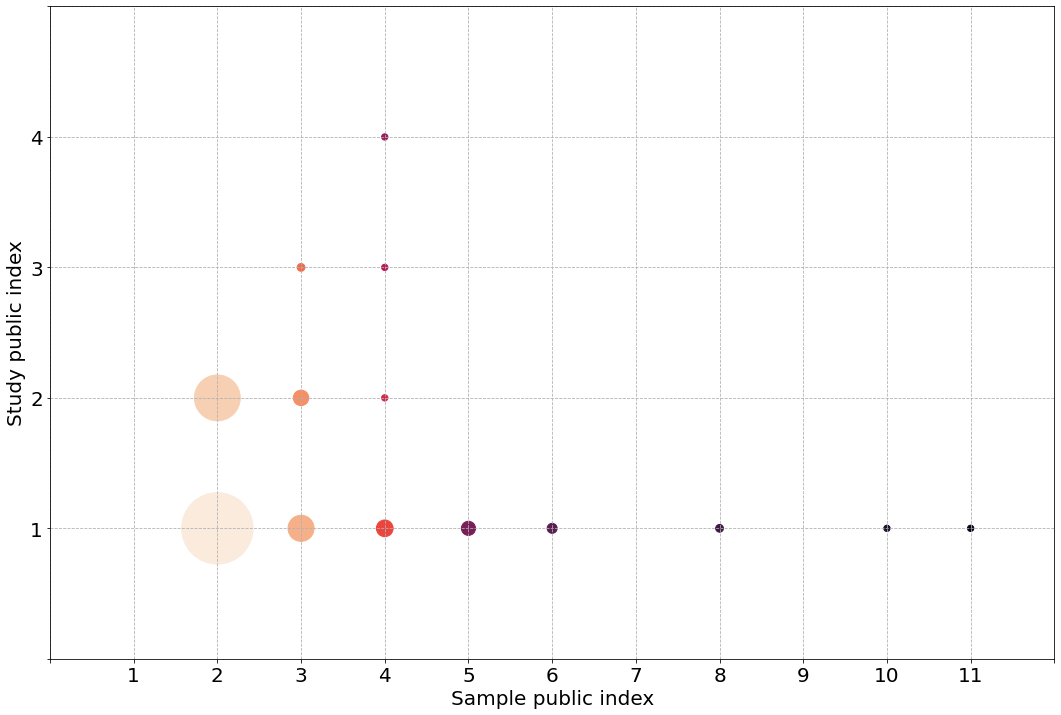

In [35]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from Levenshtein import distance as lev_dist

fig, ax = plt.subplots(1, 1, figsize=(18,12), sharey=True)
plot_feature_table = cluster_sampling_covid_feature_table.loc[covid_labels.index, cluster_sampling_covid_feature_table.apply(sum) > 1]
x_max, y_max = 0, 0
selected = plot_feature_table.loc[:, plot_feature_table.loc[covid_labels.index[~covid_labels]].apply(lambda x: sum(x)==0).to_list()]
n_subjects = selected.apply(lambda x: len(x[x!=0].reset_index().subject_id.unique()))
n_studies = selected.apply(lambda x: len(x[x!=0].reset_index().study_id.unique()))
points = pd.value_counts([(a, b) for (a,b) in zip(n_subjects, n_studies)])
s = points * 20 + 20
df = pd.DataFrame(
    [list(map(lambda x: x[0], points.index)), list(map(lambda x: x[1], points.index)), s.to_list()],
    index=['x', 'y', 's']
).transpose()
df['freq'] = points.to_list()
df['cf'] = df.y / df.x
df = df.sort_values(['x', 'y'], ascending=False)
ax.scatter(
    x='x', y='y', s='s', data=df, c=np.linspace(0, 1, len(points))[:len(points)], cmap=sns.color_palette("rocket", as_cmap=True)
)
x_max = int(max(x_max, df.x.max()))
y_max = int(max(y_max, df.y.max()))

ax.set_xticks(range(x_max+2), [""] + list(map(str, range(1, x_max+1))) + [""], fontsize=20)
ax.set_yticks(range(y_max+2), [""] + list(map(str, range(1, y_max+1))) + [""], fontsize=20)
ax.grid(axis='both', ls='--')

ax.set_xlabel('Sample public index', fontsize=20)
ax.set_ylabel('Study public index', fontsize=20)


plt.savefig(os.path.join(output_dir, 'covid_output', 'figures', 'between_samples_clones_public_indication.pdf'))


for_analyze = selected.loc[: , (n_subjects >= 8) & (n_studies == 1)]
for cluster_id in for_analyze.columns:
    study_id = for_analyze.loc[for_analyze[cluster_id] > 0].index.get_level_values(0)[0]
    print(f'***study_id {study_id}, number of samples {sum(for_analyze[cluster_id] > 0)} ***')
    cluster_frame = cluster_sampling_covid_airr_seq_df.loc[cluster_sampling_covid_airr_seq_df.cluster_id == cluster_id]
    print(f'cluster size: {len(cluster_frame)}, out of them {len(cluster_frame.apply(lambda x: x.sequence[int(x.v_sequence_start):int(x.j_sequence_end)], axis=1).unique())} are unique')
    edit_distances = []
    for i, seq1 in enumerate(cluster_frame.apply(lambda x: x.sequence[int(x.v_sequence_start):int(x.j_sequence_end)], axis=1)):
        for j, seq2 in enumerate(cluster_frame.apply(lambda x: x.sequence[int(x.v_sequence_start):int(x.j_sequence_end)], axis=1)[i+1:]):
            edit_distances.append(lev_dist(seq1, seq2)/max(len(seq1), len(seq2)))
    print(f'average nomralized edit distance between cluster sequences: {np.mean(edit_distances)}')
    print(f'v_call distribution:\n {cluster_frame.v_call_original.value_counts()}')
    if study_id == 'covid_bar_ilan':
        print(f'study has UMI, average consensus count {cluster_frame.consensus_count.mean()}, number of sequences with min consensus counts: {sum(cluster_frame.consensus_count == 2)}')

In [36]:
import pandas as pd
import os

crohn_case_metadata = pd.read_csv(
    os.path.join(input_dir, "metadata_files", "crohn_case_metadata.tsv"), sep='\t'
).set_index(["study_id", "subject_id"])
crohn_ctrl_metadata = pd.read_csv(
    os.path.join(input_dir, "metadata_files", "crohn_ctrl_metadata.tsv"), sep='\t'
).set_index(["study_id", "subject_id"])
crohn_case_train_metadata = pd.read_csv(
    os.path.join(input_dir, "metadata_files", "crohn_case_train_metadata.tsv"), sep='\t'
).set_index(["study_id", "subject_id"])


# labels of samples only used for training
crohn_case_train_labels = pd.Series(True, index=crohn_case_train_metadata.index)
# labels of sampled for the cv testing
crohn_labels = pd.concat(
    [pd.Series(True, index=crohn_case_metadata.index), pd.Series(False, index=crohn_ctrl_metadata.index)]
).drop(index=crohn_case_train_labels.index)

for folder in ['distance_matrices',  'rep_clf_output',  'subsampled_files', 'figures', 'motifs']:
    if not os.path.isdir(os.path.join(output_dir, 'crohn_output', folder)):
        os.makedirs(os.path.join(output_dir, 'crohn_output', folder))

In [37]:
# to subsample the data files we first need within-sample clustering for each
# sample file. if the file have more than 100000 we random subsample 100000 sequences
# and use them for the within-sample clustering else the clustering using DefineClones
# can take very long time - you can change this configuration with the max_sequences argument.
# if the files already have a match cluster_id field the clustering will be skipped. The
# files in the data download folder should have this field. To force within-sample clustering
# you can change the Force=False argument in the cluster_sample call to Force=True
from AbMetaAnalysis.Clustering import cluster_sample

for input_file in crohn_case_metadata.append(crohn_ctrl_metadata).input_file:
    cluster_sample(
        airr_seq_df_file_path=os.path.join(input_dir, input_file),
        max_sequences=100000,
        linkage='complete',
        dist_th=0.0,
        force=False
    )
    clear_output()

In [38]:
# if you downloaded the complete data folder the subsampling will be skipped as subsampled files with
# the correct path will already exist. in order to force subsampling you can change the force argument
# to True in the subsample_by_n_clusters and/or subsample_by_n_sequences calls
from AbMetaAnalysis.SubSample import sample_by_n_clusters, sample_by_n_sequences

sample_by_n_clusters(
    metadata=crohn_ctrl_metadata.append(crohn_case_metadata),
    input_dir=input_dir,
    output_dir=os.path.join(output_dir, 'crohn_output', 'subsampled_files'),
    n_clusters_values=[100],
    max_seq_per_cluster_values=[1],
    cluster_id_col_values=['subject_cluster_id_complete_linkage_dist_0.0'],
    force=False    
)

sample_by_n_sequences(
    metadata=crohn_ctrl_metadata.append(crohn_case_metadata),
    input_dir=input_dir,
    output_dir=os.path.join(output_dir, 'crohn_output', 'subsampled_files'),
    n_sequences_values=[100],
    force=False    
)

file /work/boazfr/data/thesis_prod/crohn_output/subsampled_files/top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv already exists - skipping sampling
file /work/boazfr/data/thesis_prod/crohn_output/subsampled_files/random_100_sequences_samples.tsv already exists - skipping sampling


<ipython-input-38-60ac6b6a7f4a>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metadata=crohn_ctrl_metadata.append(crohn_case_metadata),
<ipython-input-38-60ac6b6a7f4a>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metadata=crohn_ctrl_metadata.append(crohn_case_metadata),


In [39]:
# Group sequences in the sampled files and compute and save pair-wise distance matrices 
# of the hamming distance between the junctions. The distance matrices are required for the 
# repertoire classifications. The function checks for pre-existing distance matrices and skips
# if exists. The data folder that you downloaded should include the distance matrices but if you want to
# force a new computation you can change the force argument in the save_distance_matrices function call to True. 
from AbMetaAnalysis.Utilities import load_sampled_airr_seq_df
from AbMetaAnalysis.Clustering import save_distance_matrices

save_distance_matrices(
    load_sampled_airr_seq_df(
        file_path=os.path.join(
            output_dir, 'crohn_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
        ),
        labels=crohn_labels.append(crohn_case_train_labels),
        v_call_field="v_call_original",
        group_mode="family"
    ),
    os.path.join(
        output_dir, 'crohn_output', 'distance_matrices', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
    ),
    force=False
)

save_distance_matrices(
    load_sampled_airr_seq_df(
        file_path=os.path.join(
            output_dir, 'crohn_output', 'subsampled_files', 'random_100_sequences_samples.tsv'
        ),
        labels=crohn_labels.append(crohn_case_train_labels),
        v_call_field="v_call_original",
        group_mode="family"
    ),
    os.path.join(
        output_dir, 'crohn_output', 'distance_matrices', 'random_100_sequences_samples'
    ),
    force=False
)

<ipython-input-39-7e4f58dbe834>:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels=crohn_labels.append(crohn_case_train_labels),
<ipython-input-39-7e4f58dbe834>:29: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels=crohn_labels.append(crohn_case_train_labels),


In [40]:
# This cell run the covid repertoire samples classifier 100 folds cross validation. The cv results file should
# already be in the data directory you downladed, so the code in the cell will first try to load them. If you want 
# to force the cross validation run change the value of the covid_force_cv parameter to True but keep in mind
# that it might take some time - depending on the number of cores you have.
from AbMetaAnalysis.Utilities import load_sampled_airr_seq_df
from AbMetaAnalysis.TestRepClassifier import test_rep_classifier, load_rep_clf_results, save_rep_clf_results
from sklearn.metrics import accuracy_score, recall_score, precision_score
import numpy as np

crohn_force_cv = False

cluster_sampling_result_metrics, cluster_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
    'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.15, 'fs_method': 'naive'}
)
if crohn_force_cv or (cluster_sampling_result_metrics is None) or (cluster_sampling_result_folds is None):
    cluster_sampling_result_metrics, cluster_sampling_result_folds = test_rep_classifier(
        airr_seq_df=load_sampled_airr_seq_df(
            file_path=os.path.join(
                output_dir, 'crohn_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
            ),
            labels=crohn_labels.append(crohn_case_train_labels),
            v_call_field="v_call_original",
            group_mode="family"
        ),
        labels=crohn_labels,
        dist_mat_dir = os.path.join(
            output_dir, 'crohn_output', 'distance_matrices', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
        ),
        train_only_labels=crohn_case_train_labels,
        n_splits=len(crohn_labels),
        n_repeats=1,
        case_th_values=[1],
        ctrl_th_values=[0],
        dist_th_values=[0.15],
        feature_selection_cfg_values=[{'method': 'naive'}]
    )
    save_rep_clf_results(
        cluster_sampling_result_metrics, 
        cluster_sampling_result_folds,
        os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
        'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
    )
    cluster_sampling_result_metrics, cluster_sampling_result_folds = load_rep_clf_results(
        os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
        'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1',
        {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.15, 'fs_method': 'naive'}
    )
    clear_output()

cluster_sampling_predicts = (cluster_sampling_result_folds.loc[crohn_labels].sum(axis=1) > 0).append(
    (cluster_sampling_result_folds.loc[~crohn_labels].sum(axis=1) == 0)
)
print(
    'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1 leave one out CV:\n'
    '    accuracy: {}, precision: {}, recall: {}'.format(
        accuracy_score(crohn_labels, cluster_sampling_predicts), 
        precision_score(crohn_labels, cluster_sampling_predicts),
        recall_score(crohn_labels, cluster_sampling_predicts)
    )
)

top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1 leave one out CV:
    accuracy: 0.66, precision: 0.9, recall: 0.36


<ipython-input-40-ad7ef6b83c24>:52: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_sampling_predicts = (cluster_sampling_result_folds.loc[crohn_labels].sum(axis=1) > 0).append(


In [41]:
flipped_cluster_sampling_result_metrics, flipped_cluster_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
    'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1_flipped',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.15, 'fs_method': 'naive'}
)
flipped_crohn_labels = ~crohn_labels
if crohn_force_cv or (flipped_cluster_sampling_result_metrics is None) or (flipped_cluster_sampling_result_folds is None):
    flipped_cluster_sampling_result_metrics, flipped_cluster_sampling_result_folds = test_rep_classifier(
        airr_seq_df=load_sampled_airr_seq_df(
            file_path=os.path.join(
                output_dir, 'crohn_output', 'subsampled_files', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1.tsv'
            ),
            labels=crohn_labels.append(crohn_case_train_labels),
            v_call_field="v_call_original",
            group_mode="family"
        ),
        labels=flipped_crohn_labels,
        dist_mat_dir = os.path.join(
            output_dir, 'crohn_output', 'distance_matrices', 'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1'
        ),
        train_only_labels=crohn_case_train_labels,
        n_splits=len(crohn_labels),
        n_repeats=1,
        case_th_values=[1],
        ctrl_th_values=[0],
        dist_th_values=[0.15],
        feature_selection_cfg_values=[{'method': 'naive'}]
    )
    save_rep_clf_results(
        flipped_cluster_sampling_result_metrics, 
        flipped_cluster_sampling_result_folds,
        os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
        'top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1_flipped'
    )
    clear_output()

flipped_cluster_sampling_predicts = (flipped_cluster_sampling_result_folds.loc[~flipped_crohn_labels].sum(axis=1) == 0).append(
    (flipped_cluster_sampling_result_folds.loc[flipped_crohn_labels].sum(axis=1) > 0)
)
print(
    'flipped top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1 leave one out CV:\n'
    '    accuracy: {}, precision: {}, recall: {}'.format(
        accuracy_score(flipped_crohn_labels, flipped_cluster_sampling_predicts), 
        precision_score(flipped_crohn_labels, flipped_cluster_sampling_predicts),
        recall_score(flipped_crohn_labels, flipped_cluster_sampling_predicts)
    )
)

flipped top_100_complete_linkage_dist_0.0_clusters_max_seq_per_cluster_1 leave one out CV:
    accuracy: 0.46, precision: 0.0, recall: 0.0


<ipython-input-41-d57c72c038d1>:37: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  flipped_cluster_sampling_predicts = (flipped_cluster_sampling_result_folds.loc[~flipped_crohn_labels].sum(axis=1) == 0).append(


In [42]:
random_sampling_result_metrics, random_sampling_result_folds = load_rep_clf_results(
    os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
    'random_1000_sequences_samples',
    {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.15, 'fs_method': 'naive'}
)    
if crohn_force_cv or (random_sampling_result_metrics is None) or (random_sampling_result_folds is None):
    random_sampling_result_metrics, random_sampling_result_folds = test_rep_classifier(
        airr_seq_df=load_sampled_airr_seq_df(
            file_path=os.path.join(
                output_dir, 'crohn_output', 'subsampled_files', 'random_1000_sequences_samples.tsv'
            ),
            labels=crohn_labels.append(crohn_case_train_labels),
            v_call_field="v_call_original",
            group_mode="family"
        ),
        labels=crohn_labels,
        dist_mat_dir=os.path.join(
            output_dir, 'crohn_output', 'distance_matrices', 'random_1000_sequences_samples'
        ),
        train_only_labels=crohn_case_train_labels,
        n_splits=len(crohn_labels),
        n_repeats=1,
        case_th_values=[1],
        ctrl_th_values=[0],
        dist_th_values=[0.15],
        feature_selection_cfg_values=[{'method': 'naive'}]
    )
    save_rep_clf_results(
        random_sampling_result_metrics, 
        random_sampling_result_folds, 
        os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
        'random_1000_sequences_samples'
    )
    random_sampling_result_metrics, random_sampling_result_folds = load_rep_clf_results(
        os.path.join(output_dir, 'crohn_output', 'rep_clf_output'), 
        'random_1000_sequences_samples',
        {'case_th': 1, 'ctrl_th': 0, 'dist_th': 0.15, 'fs_method': 'naive'}
    )
    clear_output()

random_sampling_predicts = (random_sampling_result_folds.loc[crohn_labels].sum(axis=1) > 0).append(
    (random_sampling_result_folds.loc[~crohn_labels].sum(axis=1) == 0)
)
print(
    'random_1000_sequences_samples leave one out CV:\n'
    '    accuracy: {}, precision: {}, recall: {}'.format(
        accuracy_score(crohn_labels, random_sampling_predicts), 
        precision_score(crohn_labels, random_sampling_predicts),
        recall_score(crohn_labels, random_sampling_predicts)
    )
)

random_1000_sequences_samples leave one out CV:
    accuracy: 0.54, precision: 0.5263157894736842, recall: 0.8


<ipython-input-42-ecc66baab48e>:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  random_sampling_predicts = (random_sampling_result_folds.loc[crohn_labels].sum(axis=1) > 0).append(
